# Alpaca Data API
#### AJ Zerouali, 22/11/24

Goals:

* Write a downloader that uses the alpaca-py package.
* Write a processor for the data downloaded using this API.
* Adapt previously written functions in DRL_PFOpt.


In [21]:
# Kill warnings
from warnings import filterwarnings
filterwarnings("ignore")

### IMPORTS ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta, date
#import holidays # NEW, 22/11/21
import pandas_market_calendars as pd_mkt_cals

import alpaca
import MyAlpaca
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame

from DRL_PFOpt_gymEnv import PortfolioOptEnv
from DRL_PFOpt_Agent import PFOpt_DRL_Agent
#import DRL_PFOpt_Utils
#import DRL_PFOpt_Alpaca_XP
#import DRL_PFOpt_Data_XP
from DRL_PFOpt_Alpaca_XP import AlpacaDownloader
#from DRL_PFOpt_Alpaca_XP import PFOptEnv_XP ## MOMENT OF TRUTH
#from DRL_PFOpt_Alpaca_XP import Agent_XP ## MOMENT OF TRUTH
from DRL_PFOpt_Data import YahooDownloader, FeatureEngineer, data_split, get_benchmark_prices_and_returns
from DRL_PFOpt_Utils import get_str_date_format, get_market_calendar_day_list, \
                            get_timeframe_info, get_eq_wts_benchmark

# Data Downloader

## Alpaca preliminaries

* Note: REST stands for REpresentational State Transfer. See: https://rapidapi.com/blog/api-glossary/what-is-a-rest-client-rest-client-defined/

**Documentation to visit:**

* Stock data REST client, *alpaca.data.historical.StockHistoricalDataClient*: https://github.com/alpacahq/alpaca-py/blob/master/alpaca/data/historical/stock.py. This downloads the data.
* Stock data request params, *alpaca.data.requests.StockBarsRequest*: https://github.com/alpacahq/alpaca-py/blob/master/alpaca/data/requests.py. This records the parameters of a request.
* Timeframes, *alpaca.data.timeframe.TimeFrame*: https://github.com/alpacahq/alpaca-py/blob/master/alpaca/data/timeframe.py. Available timeframes can be found in that file, and include Day, Hour, Minute, Month and Week.

* Barset: This is what *StockHistoricalDataClient* downloads by default. Code: https://github.com/alpacahq/alpaca-py/blob/aec44b9e64ce19d808ce9cfa06c063e8e3c76533/alpaca/data/models/bars.py. 

* **CRUCIAL:** Here is a concrete example for downloading 3 stocks:

## Functions

In [2]:
def download_Alpaca_df(api_key: str,
                       api_secret: str,
                       start_date: str, 
                       end_date: str, 
                       ticker_list: list,
                       timeframe: str = "Day",):
    '''
        Function to download raw dataframe using Alpaca's API.
        
        :param api_key: str.
        :param api_secret: str. 
        :param start_date: datetime
        :param end_date: datetime
        :param ticker_list: list. Ticker symbols to include in dataset.
        :param timframe: str for trading period length. Should be
                            "Day", "Hour" or "Minute"
        
        :return df_data: pd.DataFrame. Raw dataset obtained from Alpaca's
                        StockHistoricalDataClient object.
    '''
    if timeframe not in ["Day", "Hour", "Minute"]:
        print("ERROR: timeframe parameter should take one of the following values:")
        print("       \"Day\", \"Hour\", or \"Minute\"")
        return None
    else:
        
        # Convert dates to datetime objects
        start_date_datetime = datetime.strptime(start_date, "%Y-%m-%d")
        end_date_datetime = datetime.strptime(end_date, "%Y-%m-%d")
        
        # Init. REST object
        stock_REST = StockHistoricalDataClient(api_key = API_KEY,
                                           secret_key= API_SECRET)
        # Get appropriate timeframe object
        # See: https://github.com/alpacahq/alpaca-py/blob/master/alpaca/data/timeframe.py
        if timeframe == "Day":
            timeframe_obj = TimeFrame.Day
        elif timeframe == "Hour":
            timeframe_obj = TimeFrame.Hour
        elif timeframe == "Minute":
            timeframe_obj = TimeFrame.Minute

        # Init. request params
        request_params = StockBarsRequest(symbol_or_symbols = ticker_list,
                                          start = start_date_datetime,
                                          end = end_date_datetime,
                                          timeframe = timeframe_obj,)
        
        # Download data
        df_data = stock_REST.get_stock_bars(request_params).df
        
        # Check for missing tickers
        #missing_tickers = list(set(df_data))
        
        return df_data

In [3]:
def format_Alpaca_download_df_columns(df_data: pd.DataFrame, 
                                      OHLCV_format: bool = True):
    '''
        Helper function to format the columns of dataframe downloaded from Alpaca.
        The output columns are in the following order:
            ["date", "open", "high", "low", "close", "volume", "tic"]
        where "tic" stands for the ticker symbol.
    
    
    :param df_data: Dataframe obtained from Alpaca.
    :param OHLCV_format: bool. Whether or not to drop the "trade_count" and "vwap" columns
                        
    :return df_X: Formatted pd.DataFrame object.
                       
    '''
    # Init.
    if OHLCV_format:
        drop_col_list =  ["trade_count", "vwap"]
        output_columns = ["date", "open", "high", "low", "close", "volume", "tic"]
        df_X = df_data.copy().drop(columns = drop_col_list)
    else:
        output_columns = ["date", "open", "high", "low", "close", "volume", "trade_count", "vwap", "tic"]
        df_X = df_data.copy()
        
    # Sort by date and ticker
    df_X = df_X.sort_values(by = ["timestamp", "symbol"])
    
    # Reset index and rename "timestamp" and "symbol" columns
    df_X = df_X.reset_index()
    df_X = df_X.rename(columns={"timestamp":"date", "symbol":"tic"})
    
    # Reorder output columns
    df_X = df_X[output_columns]
    
    return df_X
        

In [4]:
def format_Alpaca_df_date_col(df_data: pd.DataFrame,
                              timeframe: str):
    '''
        Function to format the date column
    '''
    if "date" not in list(df_data.columns):
        print("ERROR: No \"date\" column found in parameter df_data.")
        return None
    else:
        if timeframe not in ["Day", "Hour", "Minute"]:
            print("ERROR: timeframe parameter should take one of the following values:")
            print("       \"Day\", \"Hour\", or \"Minute\"")
            return None
        else:
            if timeframe == "Day":
                date_str_format = "%Y-%m-%d"
            else: 
                date_str_format = "%Y-%m-%d %H:%M"

            df_data["date"] = df_data.date.apply(lambda x: x.strftime(date_str_format))
            
            return df_data

In [5]:
def make_day_list(start_date: str, 
                  end_date: str,
                  pandas_timestamps: bool = False)->list:
    
    # Make day list
    start_date = datetime.strptime(start_date,"%Y-%m-%d")
    end_date = datetime.strptime(end_date,"%Y-%m-%d")
    n_days = (end_date-start_date).days
    day_list = []
    for i in range(n_days):
        day_list.append(start_date+timedelta(days=i))
    
    # Return output
    if not pandas_timestamps:
        return day_list
    else:
        day_list_ = [pd.to_datetime(x, utc=True) for x in day_list]
        return day_list_

In [6]:
def make_timestamp_list(start_date: str, 
                        end_date: str, 
                        timeframe: str="Hour",
                        extended_trading_hours: bool =False,
                        pandas_timestamps: bool = False)->list:
    
    if timeframe not in ["Day", "Hour", "30min", "15min"]:
        print("ERROR: timeframe parameter should be in:")
        print("       [\"Day\", \"Hour\", \"30min\", \"15min\"]")
        return None
    else:
        
        # Make day list
        start_date = datetime.strptime(start_date,"%Y-%m-%d")
        end_date = datetime.strptime(end_date,"%Y-%m-%d")
        n_days = (end_date-start_date).days
        day_list = []
        for i in range(n_days):
            day_list.append(start_date+timedelta(days=i))
        
        # timeframe = "Day" case
        if timeframe == "Day":
            timestamp_list = day_list
            #return day_list
        else:
            # Initializations
            timestamp_list = []
            ## 8-hour day format: 09:00 to 16:00
            if not extended_trading_hours:
                start_hour = timedelta(hours=9)
                n_hours = 8
            ## 16-hour day format: 08:00 to 23:00
            else:
                start_hour = timedelta(hours=8)
                n_hours = 16
            
            # timeframe="Hour" case
            if timeframe=="Hour":
                for day in day_list:
                    for i in range(n_hours):
                        timestamp_list.append(day+start_hour+timedelta(hours=i))
                
            else:
                # timeframe=="30min" case
                if timeframe=="30min":
                    delta_minutes = timedelta(minutes=30)
                    n_intra_hour = 2
                    pass
                # timeframe=="15min" case
                elif timeframe=="15min":
                    delta_minutes = timedelta(minutes=15)
                    n_intra_hour = 4
                    
                for day in day_list:
                    for i in range(n_hours-1):
                        for j in range(n_intra_hour):
                            timestamp_list.append(day+start_hour+timedelta(hours=i)+j*delta_minutes)
                    timestamp_list.append(day+start_hour+timedelta(hours=(n_hours-1)))
                    
        # Return output 
        if not pandas_timestamps:
            return timestamp_list
        else:
            timestamp_list_ = [pd.to_datetime(x, utc=True) for x in timestamp_list]
            return timestamp_list_


In [7]:
def make_intraday_timestamp_list(day: pd.Timestamp,
                                 timestamp_list: list)->list:
    '''
        For pd.Timestamp objects only
    '''
    intraday_timestamp_list = [x for x in incomplete_data_timestamp_list if (day<=x) and (x<day+timedelta(days=1))]
    return intraday_timestamp_list

In [8]:
def fill_missing_timestamps(df_data: pd.DataFrame,
                            start_date: str,
                            end_date: str,
                            timeframe: str = "Hour",
                            extended_trading_hours: bool = False,
                           )->pd.DataFrame:
    
    '''
        df_data must be the formatted downloaded.
        Before executing this function:
        1) Download using download_Alpaca_df()
        2) Apply format_Alpaca_download_df_columns() to the prev. output
        
    '''
    # Initializations
    ticker_list = list(df_data.tic.unique())
    
    full_timestamp_list = make_timestamp_list(start_date=start_date,
                                         end_date=end_date,
                                         timeframe= timeframe,
                                         extended_trading_hours=extended_trading_hours,
                                         pandas_timestamps=True,)
    
    df_out = pd.DataFrame()
    
    for tic in ticker_list:
        # Fix ticker
        df_temp = df_data[df_data.tic==tic]
        # Get missing timestamps
        missing_timestamps_list = list(set(full_timestamp_list)-set(df_temp.date.unique()))
        # Add missing timestamp rows
        df_temp = pd.concat([df_temp, pd.DataFrame({"date":missing_timestamps_list})])
        # Set "tic" column to ticker symbol
        df_temp["tic"] = tic
        # Sort by date
        df_temp = df_temp.sort_values(by="date")
        # Apply forward fill
        df_temp = df_temp.fillna(method = "ffill")
        # Apply backward fill (for missing values at the beginning)
        df_temp = df_temp.fillna(method = "bfill")
        # Append to output
        df_out = pd.concat([df_out, df_temp])
    
    # Sort and reset index
    df_out = df_out.sort_values(by=["date","tic"])
    df_out = df_out.reset_index(drop = True)
    
    return df_out
    
    

In [9]:
def truncate_df(df_data: pd.DataFrame,
                start_date: str,
                end_date: str,
                timeframe: str = "Hour",
                extended_trading_hours: bool = False,
               )->pd.DataFrame:
    '''
        This method reduces the output of fill_missing_timestamps()
        to the desired timestamps in the dataset.
    '''
    
    # Initializations
    full_timestamp_list = make_timestamp_list(start_date=start_date,
                                         end_date=end_date,
                                         timeframe= timeframe,
                                         extended_trading_hours=extended_trading_hours,
                                         pandas_timestamps=True,)
    # Truncate and reset index
    df_out = pd.DataFrame()
    df_out = df_data[df_data["date"].isin(full_timestamp_list)]
    df_out = df_out.reset_index(drop=True)
    
    return df_out

In [10]:
def process_df(df_data: pd.DataFrame,
              start_date: str,
              end_date: str,
              timeframe: str = "Hour",
              extended_trading_hours: bool = False,
              )->pd.DataFrame:
    '''
        df_data must be the formatted download.
    '''
    # Initializations
    ticker_list = list(df_data.tic.unique())
    
    day_list = make_day_list(start_date=start_date, end_date = end_date,
                            pandas_timestamps=True)
    
    full_timestamp_list = make_timestamp_list(start_date=start_date,
                                         end_date=end_date,
                                         timeframe= timeframe,
                                         extended_trading_hours=extended_trading_hours,
                                         pandas_timestamps=True,)
    df_normalized = pd.DataFrame()
    df_out = pd.DataFrame()
    
    
    # First pass: Truncate dataset and normalize dataframe
    for day in day_list:
        intraday_timestamp_list = make_intraday_timestamp_list(day, full_timestamp_list)
        for tic in ticker_list:
            # Truncate existing entries to desired ones
            df_temp = df_data[(df_data["tic"]==tic) & (df_data["date"].isin(intraday_timestamp_list))]
            # Get missing timestamps
            missing_timestamps = list(set(intraday_timestamp_list)-set(df_temp.date))
            # Add rows for missing timestamps
            df_temp = pd.concat([df_temp,pd.DataFrame({"date":missing_timestamps})])
            # Fill the ticker column
            df_temp["tic"] = tic
            # Sort
            df_temp = df_temp.sort_values(by="date")
            # Append to output
            df_normalized = pd.concat([df_normalized,df_temp])
        
    # Second pass: Fill missing values
    #del df_temp
    for tic in ticker_list:
        df_temp = df_normalized[df_normalized["tic"]==tic]
        df_temp = df_temp.fillna(method = "ffill")
        df_temp = df_temp.fillna(method = "bfill")
        df_out = pd.concat([df_out,df_temp])        
     
    df_out = df_out.sort_values(by=["date", "tic"])
    df_out = df_out.reset_index(drop = True)
    
    return df_out

In [11]:
def normalize_df(df_data: pd.DataFrame,
              start_date: str,
              end_date: str,
              timeframe: str = "Hour",
              extended_trading_hours: bool = False,
              )->pd.DataFrame:
    '''
        df_data must be the formatted downloaded.
    '''
    # Initializations
    ticker_list = list(df_data.tic.unique())
    
    day_list = make_day_list(start_date=start_date, end_date = end_date,
                            pandas_timestamps=True)
    
    full_timestamp_list = make_timestamp_list(start_date=start_date,
                                         end_date=end_date,
                                         timeframe= timeframe,
                                         extended_trading_hours=extended_trading_hours,
                                         pandas_timestamps=True,)
    df_out = pd.DataFrame()
    
    # First pass only
    for day in day_list:
        intraday_timestamp_list = make_intraday_timestamp_list(day, full_timestamp_list)
        for tic in ticker_list:
            # Truncate existing entries to desired ones
            df_temp = df_data[(df_data["tic"]==tic) & (df_data["date"].isin(intraday_timestamp_list))]
            # Get missing timestamps
            missing_timestamps = list(set(intraday_timestamp_list)-set(df_temp.date))
            # Add rows for missing timestamps
            df_temp = pd.concat([df_temp,pd.DataFrame({"date":missing_timestamps})])
            # Fill the ticker column
            df_temp["tic"] = tic
            # Sort
            df_temp = df_temp.sort_values(by="date")
            # Append to output
            df_out = pd.concat([df_out,df_temp])
        
                
    return df_out

### Tests

In [24]:
df_X = pd.read_csv(filepath_or_buffer="./datasets/Alpaca_data_hour_example.csv",
                   #index_col="timestamp",
                    usecols=["timestamp","symbol","open", "high", "low", "close", "volume"],
                  parse_dates=True)

In [11]:
del df_data, df_X

In [6]:
### API KEYS ###
API_KEY = MyAlpaca.API_KEY
API_SECRET = MyAlpaca.API_SECRET

In [65]:
### REQUEST PARAMETERS ###
#ticker_list = ["AAPL", "MSFT", "JPM"]
ticker_list = ["AAPL", "MSFT", "JPM", "INTC", "AMZN"]
#start_date = "2022-10-15"
start_date = "2022-10-17"
#end_date = "2022-11-01"
end_date = "2022-10-20"

In [13]:
df_data = download_Alpaca_df(api_key= API_KEY,
                             api_secret = API_SECRET,
                             start_date = start_date,
                             end_date = end_date,
                             ticker_list = ticker_list,
                             timeframe = 'Hour')

In [14]:
df_data.to_csv(path_or_buf = "./datasets/Alpaca_data_hour_example.csv",
              )

In [122]:
df_Y = download_Alpaca_df(api_key= API_KEY,
                             api_secret = API_SECRET,
                             start_date = "2022-10-17",
                             end_date = "2022-10-18",
                             ticker_list = ["MSFT"],
                             timeframe = 'Hour')

In [123]:
df_Y = format_Alpaca_download_df_columns(df_Y)

In [132]:
df_Y["date"] = df_Y.date.apply(lambda x: pd.to_datetime(arg=x,format="%Y-%m-%d %H:%M"))

In [168]:
df_Y.head()

,date,open,high,low,close,volume,tic
0,2022-10-17 08:00:00+00:00,232.000,232.05,231.080,231.45,19160.0,MSFT
1,2022-10-17 09:00:00+00:00,231.500,231.68,231.500,231.55,3927.0,MSFT
2,2022-10-17 10:00:00+00:00,231.450,232.93,231.400,231.82,11841.0,MSFT
3,2022-10-17 11:00:00+00:00,232.000,232.30,231.340,232.00,85745.0,MSFT
4,2022-10-17 12:00:00+00:00,227.989,233.49,227.989,233.33,118001.0,MSFT


## **Downloading incomplete data**

We'll consider a set of stocks and dates with a lot of missing data.

The following is very useful:
    
    df_Y[df_Y["date"].isin(date_list_ex)].


In [12]:
### API KEYS ###
API_KEY = MyAlpaca.API_KEY
API_SECRET = MyAlpaca.API_SECRET

In [13]:
incomplete_data_start_date = "2018-02-05"
incomplete_data_end_date="2018-02-08"
incomplete_data_ticker_list = ["V", "DIS", "DOW", "INTC"]

In [15]:
incomplete_data_day_list = make_day_list(start_date = incomplete_data_start_date,
                                         end_date = incomplete_data_end_date,
                                        pandas_timestamps=True)
incomplete_data_timestamp_list = make_timestamp_list(start_date = incomplete_data_start_date,
                                                     end_date = incomplete_data_end_date,
                                                     timeframe="Hour",
                                                     extended_trading_hours=False,
                                                     pandas_timestamps=True)

In [14]:
df_X_0 = download_Alpaca_df(api_key=API_KEY, api_secret = API_SECRET,
                             start_date=incomplete_data_start_date,
                            end_date=incomplete_data_end_date,
                            ticker_list=incomplete_data_ticker_list,
                            timeframe = "Hour")
df_X = format_Alpaca_download_df_columns(df_X_0)
df_X_0 = df_X_0.reset_index()

In [16]:
df_X.head()

,date,open,high,low,close,volume,tic
0,2018-02-05 09:00:00+00:00,46.30,46.30,46.00,46.00,1130.0,INTC
1,2018-02-05 09:00:00+00:00,120.00,120.00,120.00,120.00,300.0,V
2,2018-02-05 11:00:00+00:00,108.00,108.00,108.00,108.00,120.0,DIS
3,2018-02-05 11:00:00+00:00,45.91,45.91,45.75,45.75,2327.0,INTC
4,2018-02-05 11:00:00+00:00,119.50,119.50,119.50,119.50,1057.0,V


**Checking timestamp list**

In [17]:
incomplete_data_timestamp_list

[Timestamp('2018-02-05 09:00:00+0000', tz='UTC'),
 Timestamp('2018-02-05 10:00:00+0000', tz='UTC'),
 Timestamp('2018-02-05 11:00:00+0000', tz='UTC'),
 Timestamp('2018-02-05 12:00:00+0000', tz='UTC'),
 Timestamp('2018-02-05 13:00:00+0000', tz='UTC'),
 Timestamp('2018-02-05 14:00:00+0000', tz='UTC'),
 Timestamp('2018-02-05 15:00:00+0000', tz='UTC'),
 Timestamp('2018-02-05 16:00:00+0000', tz='UTC'),
 Timestamp('2018-02-06 09:00:00+0000', tz='UTC'),
 Timestamp('2018-02-06 10:00:00+0000', tz='UTC'),
 Timestamp('2018-02-06 11:00:00+0000', tz='UTC'),
 Timestamp('2018-02-06 12:00:00+0000', tz='UTC'),
 Timestamp('2018-02-06 13:00:00+0000', tz='UTC'),
 Timestamp('2018-02-06 14:00:00+0000', tz='UTC'),
 Timestamp('2018-02-06 15:00:00+0000', tz='UTC'),
 Timestamp('2018-02-06 16:00:00+0000', tz='UTC'),
 Timestamp('2018-02-07 09:00:00+0000', tz='UTC'),
 Timestamp('2018-02-07 10:00:00+0000', tz='UTC'),
 Timestamp('2018-02-07 11:00:00+0000', tz='UTC'),
 Timestamp('2018-02-07 12:00:00+0000', tz='UTC'),


In [18]:
len(incomplete_data_timestamp_list)

24

**Checking data cleaner**

In [19]:
df_Y = fill_missing_timestamps(df_data = df_X,
                            start_date = incomplete_data_start_date,
                            end_date = incomplete_data_end_date,
                            timeframe = "Hour",
                            extended_trading_hours = False,
                           )

In [21]:
len(incomplete_data_timestamp_list)

24

In [20]:
len(df_X)

133

In [22]:
len(df_Y)

141

In [24]:
df_Y[df_Y["tic"]=="DIS"]

,date,open,high,low,close,volume,tic
0,2018-02-05 09:00:00+00:00,108.000,108.0000,108.0000,108.0000,120.0,DIS
3,2018-02-05 10:00:00+00:00,108.000,108.0000,108.0000,108.0000,120.0,DIS
6,2018-02-05 11:00:00+00:00,108.000,108.0000,108.0000,108.0000,120.0,DIS
9,2018-02-05 12:00:00+00:00,107.490,107.6000,106.7100,106.7100,3678.0,DIS
12,2018-02-05 13:00:00+00:00,106.610,108.0000,106.5500,107.9000,7556.0,DIS
15,2018-02-05 14:00:00+00:00,107.540,108.1500,106.4200,107.8100,1594527.0,DIS
18,2018-02-05 15:00:00+00:00,107.780,108.6300,107.6300,108.4300,1479875.0,DIS
21,2018-02-05 16:00:00+00:00,108.440,108.5990,107.9700,108.1900,1030845.0,DIS
24,2018-02-05 17:00:00+00:00,108.200,108.2000,107.1500,107.1800,2004129.0,DIS
27,2018-02-05 18:00:00+00:00,107.170,108.0014,106.4600,107.0100,1346778.0,DIS


In [28]:
df_Z = truncate_df(df_data=df_Y,
                start_date = incomplete_data_start_date,
                end_date = incomplete_data_end_date,
                timeframe = "Hour",
                extended_trading_hours = False,
               )

In [29]:
len(df_Z)

72

In [31]:
df_Z[df_Z["tic"]=="INTC"]

,date,open,high,low,close,volume,tic
1,2018-02-05 09:00:00+00:00,46.300,46.3000,46.0000,46.00,1130.0,INTC
4,2018-02-05 10:00:00+00:00,46.300,46.3000,46.0000,46.00,1130.0,INTC
7,2018-02-05 11:00:00+00:00,45.910,45.9100,45.7500,45.75,2327.0,INTC
10,2018-02-05 12:00:00+00:00,45.800,45.9700,45.4000,45.95,53615.0,INTC
13,2018-02-05 13:00:00+00:00,45.710,46.5600,45.5000,46.40,92580.0,INTC
16,2018-02-05 14:00:00+00:00,46.310,46.5550,46.1000,46.40,5242519.0,INTC
19,2018-02-05 15:00:00+00:00,46.400,47.2600,46.3800,47.05,5502068.0,INTC
22,2018-02-05 16:00:00+00:00,47.045,47.2000,46.7500,46.90,2957376.0,INTC
25,2018-02-06 09:00:00+00:00,44.180,44.3000,44.1000,44.30,1378.0,INTC
28,2018-02-06 10:00:00+00:00,44.110,44.2200,44.0100,44.22,11902.0,INTC


In [40]:
df_Z_ = format_Alpaca_df_date_col(df_Z, timeframe = "Hour")

In [41]:
df_Z_[df_Z_["tic"]=="INTC"]

,date,open,high,low,close,volume,tic
1,2018-02-05 09:00,46.300,46.3000,46.0000,46.00,1130.0,INTC
4,2018-02-05 10:00,46.300,46.3000,46.0000,46.00,1130.0,INTC
7,2018-02-05 11:00,45.910,45.9100,45.7500,45.75,2327.0,INTC
10,2018-02-05 12:00,45.800,45.9700,45.4000,45.95,53615.0,INTC
13,2018-02-05 13:00,45.710,46.5600,45.5000,46.40,92580.0,INTC
16,2018-02-05 14:00,46.310,46.5550,46.1000,46.40,5242519.0,INTC
19,2018-02-05 15:00,46.400,47.2600,46.3800,47.05,5502068.0,INTC
22,2018-02-05 16:00,47.045,47.2000,46.7500,46.90,2957376.0,INTC
25,2018-02-06 09:00,44.180,44.3000,44.1000,44.30,1378.0,INTC
28,2018-02-06 10:00,44.110,44.2200,44.0100,44.22,11902.0,INTC


**Verification with extended hours**

In [34]:
df_Y_ext = fill_missing_timestamps(df_data = df_X,
                            start_date = incomplete_data_start_date,
                            end_date = incomplete_data_end_date,
                            timeframe = "Hour",
                            extended_trading_hours = True,
                           )
df_Z_ext = truncate_df(df_data=df_Y_ext,
                start_date = incomplete_data_start_date,
                end_date = incomplete_data_end_date,
                timeframe = "Hour",
                extended_trading_hours = True,
               )

In [35]:
len(df_Z_ext)

144

In [38]:
df_Z_ext[df_Z_ext["tic"]=="DIS"].iloc[-16:]

,date,open,high,low,close,volume,tic
96,2018-02-07 08:00:00+00:00,109.200,109.30,109.1400,109.2800,12900.0,DIS
99,2018-02-07 09:00:00+00:00,109.200,109.30,109.1400,109.2800,12900.0,DIS
102,2018-02-07 10:00:00+00:00,109.200,109.30,109.1400,109.2800,12900.0,DIS
105,2018-02-07 11:00:00+00:00,108.250,108.50,108.1100,108.2500,3661.0,DIS
108,2018-02-07 12:00:00+00:00,108.250,108.50,107.6000,108.5000,35260.0,DIS
111,2018-02-07 13:00:00+00:00,108.250,108.55,107.5600,108.1000,104730.0,DIS
114,2018-02-07 14:00:00+00:00,108.500,108.75,105.6301,107.1097,2333510.0,DIS
117,2018-02-07 15:00:00+00:00,107.125,107.30,106.2600,106.7100,1912020.0,DIS
120,2018-02-07 16:00:00+00:00,106.780,107.38,106.2100,106.4050,1049012.0,DIS
123,2018-02-07 17:00:00+00:00,106.390,106.43,105.7100,105.7500,1328348.0,DIS


****

# YahooDownloader 

This part is:

1) A sanity check for the desired output data format.
2) A verification of the updates made to the YahooDownloader class.

In [2]:
from DRL_PFOpt_Data import YahooDownloader as YahooDownloader_ini
from DRL_PFOpt_Data_XP import YahooDownloader

In [3]:
df_ini = YahooDownloader_ini(start_date = "2022-10-17",
                     end_date = "2022-10-20",
                     ticker_list =["AAPL", "JPM", "MSFT"]).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (9, 8)


In [5]:
yahoo_downloader = YahooDownloader()
df = yahoo_downloader.fetch_data(start_date = "2022-10-17",
                                 end_date = "2022-10-20",
                                 ticker_list =["AAPL", "JPM", "MSFT"],
                                 include_day_of_week=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (9, 7)


In [6]:
df_ini

,date,open,high,low,close,volume,tic,day
0,2022-10-17,141.070007,142.899994,140.270004,142.174164,85250900,AAPL,0
1,2022-10-17,115.410004,117.010002,114.320000,115.860001,22276300,JPM,0
2,2022-10-17,235.820007,238.960007,235.139999,236.862488,28142300,MSFT,0
3,2022-10-18,145.490005,146.699997,140.610001,143.511932,99136600,AAPL,1
4,2022-10-18,119.660004,120.139999,116.959999,118.839996,21539700,JPM,1
5,2022-10-18,243.240005,243.929993,235.369995,237.829758,26329600,MSFT,1
6,2022-10-19,141.690002,144.949997,141.500000,143.621750,61758300,AAPL,2
7,2022-10-19,117.989998,118.830002,115.669998,116.510002,17072000,JPM,2
8,2022-10-19,237.039993,239.610001,234.289993,235.815430,19985700,MSFT,2


In [7]:
df

,date,open,high,low,close,volume,tic
0,2022-10-17,141.070007,142.899994,140.270004,142.174164,85250900,AAPL
1,2022-10-17,115.410004,117.010002,114.320000,115.860001,22276300,JPM
2,2022-10-17,235.820007,238.960007,235.139999,236.862488,28142300,MSFT
3,2022-10-18,145.490005,146.699997,140.610001,143.511932,99136600,AAPL
4,2022-10-18,119.660004,120.139999,116.959999,118.839996,21539700,JPM
5,2022-10-18,243.240005,243.929993,235.369995,237.829758,26329600,MSFT
6,2022-10-19,141.690002,144.949997,141.500000,143.621750,61758300,AAPL
7,2022-10-19,117.989998,118.830002,115.669998,116.510002,17072000,JPM
8,2022-10-19,237.039993,239.610001,234.289993,235.815430,19985700,MSFT


# AlpacaDownloader class

In [2]:
###################################
### Downloader Class for Alpaca ###
###################################
class AlpacaDownloader:
    '''
        Helper class for downloading stock historical data 
        from Alpaca. See docstring of fetch_data() for
        detailed description.
        
        ATTRIBUTES:
        ===========
        
        :param api_key: Alpaca API key.
        :param api_secret: Alpaca API secret code.
        
        METHODS:
        ========
        
        fetch_data(): Main function for downloading and returning
                    formatted dataframe.
        check_timeframe(): Helper function for checking admissibility
                    of the timeframe keyword.
        download_Alpaca_df(): Method to download raw data using the
                    Alpaca API (alpaca-py package).
        format_download_columns(): Method to create the "date" and "tic"
                    columns from the raw data, and for re-ordering the
                    input columns.
        make_timestamp_list(): Helper method to create the timestamp
                    list of the output dataset.
        fill_missing_timestamps(): Method to back-fill or forward-fill
                    the timestamps missing from the output of
                    make_timestamp_list().
        truncate_df(): Method to reduce the dataset to the timestamps
                    included in the output of make_timestamp_list().
        format_date_col(): Converts the entries of the "date" column
                    of the output dataframe to str.
    '''
    ###################
    ### Constructor ###
    ###################
    def __init__(self, 
                 api_key: str, 
                 api_secret: str,
                 ):
        self.api_key = api_key
        self.api_secret = api_secret

    ##################
    ### Fetch Data ###
    ##################
    def fetch_data(self,
                   start_date: str, 
                   end_date: str, 
                   ticker_list: list,
                   timeframe: str = "Hour",
                   extended_trading_hours: bool = False,
                   OHLCV_format: bool = True,
                   convert_dates_to_str: bool = True,
                  )->pd.DataFrame:
        '''
            Main function of the class. Downloads the stock historical
            data from Alpaca, fills the missing timestamps from the
            desired timeframe, and returns a dataset with the format
            used for PortfolioOptEnv.
            
            :param start_date: str. Start date of dataset.
            :param end_date: str. End date of dataset (not included).
            :param ticker_list: list. Ticker symbols to download.
            :param timeframe: str in ["Day", "Hour", "30min", "15min"].
            :param extended_trading_hours: bool. If False (default), each day in the output
                    dataframe contains data on 8 hours (9:00 to 16:00).
                    If True, the output contains data on 16 hours (8:00 to 23:00).
            :param OHLCV_format: bool. If False, keeps the "trade_count" and "vwap"
                    columns downloaded by default. True by default.
            :param convert_dates_to_str: bool. Whether to convert entries of the "date" column
                    of output dataframe to string objects. True by default, and if False
                    the "date" entries are pd.Timestamp objects.
            
            :return df_out: pd.DataFrame of formatted dataset.
        '''
        # Convert dates to datetime objects
        start_date_ = datetime.strptime(start_date, "%Y-%m-%d")
        end_date_ = datetime.strptime(end_date, "%Y-%m-%d")
        
        # Raise ValueError if dates are incoherent
        if end_date_<= start_date_:
            raise ValueError("Given end_date precedes start_date.") 
        
        # Download data
        df_data = self.download_Alpaca_df(start_date = start_date_,
                                          end_date=end_date_, 
                                          ticker_list = ticker_list,
                                          timeframe = timeframe,)
        
        # Format columns of downloaded dataframe
        df_data = self.format_download_columns(df_data = df_data,
                                               OHLCV_format = OHLCV_format,)
            
        # Print ignored tickers if any:
        missing_tickers_list = list(set(ticker_list) - set(df_data.tic.unique()))
        if len(missing_tickers_list)>0:
            print("Due to unavailable data, the following tickers have been omitted:")
            print(missing_tickers_list)
                
        # Make target timestamp list
        target_timestamp_list = self.make_timestamp_list(start_date = start_date_,
                                                         end_date = end_date_,
                                                         timeframe= timeframe,
                                                         extended_trading_hours = extended_trading_hours,
                                                         pandas_timestamps = True,)
        
        # Fill missing timestamps from downloaded data
        df_data = self.fill_missing_timestamps(df_data = df_data,
                                               target_timestamp_list = target_timestamp_list,)
            
        # Drop rows with timestamps not included in target_timestamp_list
        df_out = self.truncate_df(df_data = df_data,
                                  target_timestamp_list = target_timestamp_list,)
        
        # Format date column of output dataset
        if convert_dates_to_str:
            df_out = self.format_date_col(df_data = df_out,
                                          timeframe = timeframe)
        
        return df_out
    
    #############################
    ### Check timeframe param ###
    #############################
    def check_timeframe(self,
                        timeframe: str):
        '''
            Method to check if the timeframe keyword is included in: 
            ["Day", "Hour", "30min", "15min"]. Returns True if it is
            the case, and raises a ValueError exception otherwise.
            
            :param timeframe: str. Keyword controlling the size and contents
                        of the output dataset.
        '''
        if timeframe not in ["Day", "Hour", "30min", "15min"]:
            raise ValueError("The timeframe parameter must be one of the following keywords:\n"\
                             "            \"Day\", \"Hour\", \"30min\", or  \"15min\"")
        else:
            return True
        
    
    #####################
    ### Download Data ###
    #####################
    def download_Alpaca_df(self, 
                           start_date: datetime, 
                           end_date: datetime, 
                           ticker_list: list,
                           timeframe: str = "Hour",
                          )->pd.DataFrame:
        
        '''
            Method to download raw dataframe using Alpaca's API.

            :param start_date: datetime object.
            :param end_date: datetime object.
            :param ticker_list: list. Ticker symbols to include in dataset.
            :param timframe: str for trading period length. Should be
                                "Day", "Hour", "30min", or "15min".

            :return df_data: pd.DataFrame. Raw dataset obtained from Alpaca's
                            StockHistoricalDataClient object.

        '''
        if self.check_timeframe(timeframe):
            
            # Init. REST object
            stock_REST = StockHistoricalDataClient(api_key = self.api_key,
                                                   secret_key= self.api_secret)
            # Get appropriate timeframe object
            # See: https://github.com/alpacahq/alpaca-py/blob/master/alpaca/data/timeframe.py
            if timeframe == "Day":
                timeframe_obj = TimeFrame.Day
            elif timeframe == "Hour":
                timeframe_obj = TimeFrame.Hour
            # Cases of "30min" and "15min" 
            else:
                timeframe_obj = TimeFrame.Minute

            # Init. request params
            request_params = StockBarsRequest(symbol_or_symbols = ticker_list,
                                              start = start_date,
                                              end = end_date,
                                              timeframe = timeframe_obj,)

            # Download data
            df_data = stock_REST.get_stock_bars(request_params).df

            return df_data
    
    ###############################
    ### Format Download Columns ###
    ###############################
    def format_download_columns(self, 
                                df_data: pd.DataFrame,
                                OHLCV_format: bool = True,
                               )->pd.DataFrame:
        '''
            Helper function to format the columns of dataframe downloaded from Alpaca.
            The output columns are in the following order:
                ["date", "open", "high", "low", "close", "volume", "tic"]
            where "tic" stands for the ticker symbol.


            :param df_data: Dataframe obtained from Alpaca.
            :param OHLCV_format: bool. Whether or not to drop the "trade_count" and "vwap" columns
                        downloaded by Alpaca.

            :return df_X: Formatted pd.DataFrame object.

        '''
        # Init.
        if OHLCV_format:
            drop_col_list =  ["trade_count", "vwap"]
            output_columns = ["date", "open", "high", "low", "close", "volume", "tic"]
            df_X = df_data.copy().drop(columns = drop_col_list)
        else:
            output_columns = ["date", "open", "high", "low", "close", "volume", "trade_count", "vwap", "tic"]
            df_X = df_data.copy()

        # Sort by date and ticker
        df_X = df_X.sort_values(by = ["timestamp", "symbol"])

        # Reset index and rename "timestamp" and "symbol" columns
        df_X = df_X.reset_index()
        df_X = df_X.rename(columns={"timestamp":"date", "symbol":"tic"})

        # Reorder output columns
        df_X = df_X[output_columns]

        return df_X
    
    ###########################
    ### Make Timestamp List ###
    ###########################
    def make_timestamp_list(self, 
                            start_date: datetime, 
                            end_date: datetime,
                            timeframe: str="Hour",
                            extended_trading_hours: bool =False,
                            pandas_timestamps: bool = False,
                           )->list:
        '''
            Method to build the list of timestamps to include
            in the output dataset.
            
            :param start_date: datetime object.
            :param end_date: datetime object.
            :param timeframe: str keyword from ["Day", "Hour", "30min", "15min"].
            :param extended_trading_hours: If False (default), each day in the output
                    dataframe contains data on 8 hours (9:00 to 16:00).
                    If True, the output contains data on 16 hours (8:00 to 23:00).
            :param pandas_timestamps: bool. If False (default), the output list consists of 
                    datetime instances. If True, these are converted to pd.Timestamp objects.
                            
            :return timestamp_list: List of timestamps to include in the output 
                    dataframe of fetch_data().
        '''
        # Raise ValueError if dates are incoherent
        if end_date<= start_date:
            raise ValueError("Given end_date precedes start_date.") 
            
        if self.check_timeframe(timeframe):
            '''
                22/11/21: I fucked-up big time here. 
                    I have to check if any elements in day_list
                    are holidays or on a weekend.
            
            n_days = (end_date-start_date).days
            day_list = []
            for i in range(n_days):
                day_list.append(start_date+timedelta(days=i))
            '''
            day_list = get_market_calendar_day_list(start_date=start_date,
                                                   end_date = end_date,
                                                   calendar_name = "NASDAQ")
            #n_days = len(day_list)

            # timeframe = "Day" case
            if timeframe == "Day":
                timestamp_list = day_list
                #return day_list
            else:
                # Initializations
                timestamp_list = []
                ## 8-hour day format: 09:00 to 16:00
                if not extended_trading_hours:
                    start_hour = timedelta(hours=9)
                    n_hours = 8
                ## 16-hour day format: 08:00 to 23:00
                else:
                    start_hour = timedelta(hours=8)
                    n_hours = 16

                # timeframe="Hour" case
                if timeframe=="Hour":
                    for day in day_list:
                        for i in range(n_hours):
                            timestamp_list.append(day+start_hour+timedelta(hours=i))

                else:
                    # timeframe=="30min" case
                    if timeframe=="30min":
                        delta_minutes = timedelta(minutes=30)
                        n_intra_hour = 2
                        pass
                    # timeframe=="15min" case
                    elif timeframe=="15min":
                        delta_minutes = timedelta(minutes=15)
                        n_intra_hour = 4

                    for day in day_list:
                        for i in range(n_hours-1):
                            for j in range(n_intra_hour):
                                timestamp_list.append(day+start_hour+timedelta(hours=i)+j*delta_minutes)
                        timestamp_list.append(day+start_hour+timedelta(hours=(n_hours-1)))

            # Return output 
            if not pandas_timestamps:
                return timestamp_list
            else:
                timestamp_list_ = [pd.to_datetime(x, utc=True) for x in timestamp_list]
                return timestamp_list_
            

    ###############################
    ### Fill Missing Timestamps ###
    ###############################
    def fill_missing_timestamps(self, 
                                df_data: pd.DataFrame,
                                target_timestamp_list: list,
                               )->pd.DataFrame:
    
        '''
            Method to add the dates in target_timestamp_list to df_data in
            case they are missing. Uses Pandas pd.DataFrame.fillna() with
            both "bfill" and "ffill".
            Typically, df_data is the output of format_download_columns()
            and target_timestamp_list is the output of make_timestamp_list().
            
            :param df_data: pd.DataFrame of downloaded data with formatted
                    columns.
            :param target_timestamp_list: List of timestamps that must be
                    included in the output dataframe.
            
            :return df_out: pd.DataFrame with timestamps originally downloaded
                    plus those in target_timestamp_list.

        '''
        if "date" not in list(df_data.columns):
            raise ValueError("No \"date\" column found in parameter df_data.")
            
        if not all(isinstance(x,pd.Timestamp) for x in target_timestamp_list):
            raise ValueError("All entries of target_timestamp_list must be instances "\
                             "of pd.Timestamp.")
        
        # Initializations
        ticker_list = list(df_data.tic.unique())
        df_out = pd.DataFrame()

        for tic in ticker_list:
            # Fix ticker
            df_temp = df_data[df_data.tic==tic]
            # Get missing timestamps
            missing_timestamps_list = list(set(target_timestamp_list)-set(df_temp.date.unique()))
            # Add missing timestamp rows
            df_temp = pd.concat([df_temp, pd.DataFrame({"date":missing_timestamps_list})])
            # Set "tic" column to ticker symbol
            df_temp["tic"] = tic
            # Sort by date
            df_temp = df_temp.sort_values(by="date")
            # Apply forward fill
            df_temp = df_temp.fillna(method = "ffill")
            # Apply backward fill (for missing values at the beginning)
            df_temp = df_temp.fillna(method = "bfill")
            # Append to output
            df_out = pd.concat([df_out, df_temp])

        # Sort and reset index
        df_out = df_out.sort_values(by=["date","tic"])
        df_out = df_out.reset_index(drop = True)

        return df_out
    
    ##########################
    ### Truncate DataFrame ###
    ##########################
    def truncate_df(self, 
                    df_data: pd.DataFrame,
                    target_timestamp_list: list,
                   )->pd.DataFrame:
        '''
            Method to reduce the downloaded data to the timestamps specified
            in target_timestamp_list.
            Typically, df_data is the output of fill_missing_timestamps()
            and target_timestamp_list is the output of make_timestamp_list().
            
            :param df_data: pd.DataFrame of downloaded data with formatted
                    columns and no missing timestamps.
            :param target_timestamp_list: List of timestamps that must be
                    included in the output dataframe.
            
            :return df_out: pd.DataFrame with whose date column entries are exactly
                    those in target_timestamp_list.
        '''
        if "date" not in list(df_data.columns):
            raise ValueError("No \"date\" column found in parameter df_data.")
            
        if not all(isinstance(x,pd.Timestamp) for x in target_timestamp_list):
            raise ValueError("All entries of target_timestamp_list must be instances "\
                             "of pd.Timestamp.")
            
        # Truncate and reset index
        df_out = pd.DataFrame()
        df_out = df_data[df_data["date"].isin(target_timestamp_list)]
        df_out = df_out.reset_index(drop=True)

        return df_out
    
    ##########################
    ### Format Date Column ###
    ##########################
    def format_date_col(self,
                        df_data: pd.DataFrame,
                        timeframe: str,
                       )->pd.DataFrame:
        '''
            Method to convert the entries of the "date" column
            in df_data to strings with the "%Y-%m-%d" or
            the "%Y-%m-%d %H:%M" format.
            Typically, df_data is the output of truncate_df().
            
            :param df_data: pd.DataFrame of processed dataset.
            :param timeframe: str. Keyword in ["Day", "Hour", "30min", "15min"].
            
            :return df_data:
        '''
        if "date" not in list(df_data.columns):
            raise ValueError("No \"date\" column found in parameter df_data.")
        
        if not all(isinstance(x,datetime) for x in list(df_data.date.unique())):
            raise ValueError("All entries of the \"date\" column of df_data must be instances "\
                             "of datetime.datetime or pd.Timestamp.")
        
        if self.check_timeframe(timeframe):
            if timeframe == "Day":
                date_str_format = "%Y-%m-%d"
            else:
                date_str_format = "%Y-%m-%d %H:%M"

            df_data["date"] = df_data.date.apply(lambda x: x.strftime(date_str_format))

            return df_data


## Tests: Hourly data with missing timestamps

Goals:

* Test the *AlpacaDownloader* class on a set of tickers with missing data. The DOW ticker below will be dropped.
* Verify output of "Hour", "30min", and "15min" timeframes.
* Verify output with and without extended trading hours.

Notes:

* For this test, we take 3 days.
* For timeframe = "Hour" and extended_trading_hours = False:
    * The timestamp list should contain 24=3x8 elements.
    * The length of the dataframe should be 72=3x24.
* For timeframe = "Hour" and extended_trading_hours = True:
    * The timestamp list should contain 48=3x16 elements.
    * The length of the dataframe should be 144=3x48.
* For timeframe = "30min" and extended_trading_hours = False:
    * The timestamp list should contain 45=3x15 elements (15 = 7x2+1 for intraday timestamps).
    * The length of the dataframe should be 135=3x45.
* For timeframe = "30min" and extended_trading_hours = True:
    * The timestamp list should contain 93=3x15 elements (31 = 15x2+1 for intraday timestamps).
    * The length of the dataframe should be 279=3x93.
* For timeframe = "15min" and extended_trading_hours = False:
    * The timestamp list should contain 87=3x29 elements (29 = 7x4+1 for intraday timestamps).
    * The length of the dataframe should be 261=3x87.
* For timeframe = "15min" and extended_trading_hours = True:
    * The timestamp list should contain 183=3x61 elements (61 = 15x4+1 for intraday timestamps).
    * The length of the dataframe should be 549=3x183.
* For timeframe = "Day":
    * The timestamp list should contain 3 elements
    * The length of the dataframe should be 12. DOW is not omitted for the daily values.

In [10]:
### API KEYS ###
API_KEY = MyAlpaca.API_KEY
API_SECRET = MyAlpaca.API_SECRET

In [11]:
# Data for download request
start_date = "2018-02-05"
end_date="2018-02-08"
ticker_list = ["V", "DIS", "DOW", "INTC"]

In [20]:
downloader = AlpacaDownloader(api_key=API_KEY, api_secret=API_SECRET)

In [19]:
del downloader, df_hour

### timeframe = "Hour" and extended_trading_hours = False:

In [21]:
df_hour = downloader.fetch_data(start_date = start_date,
                                end_date = end_date,
                                ticker_list = ticker_list,
                                timeframe= 'Hour',
                                extended_trading_hours = False,
                                OHLCV_format = True,
                                convert_dates_to_str= True)

Due to unavailable data, the following tickers have been ignored:
['DOW']


In [22]:
len(df_hour.date.unique())

24

In [23]:
len(df_hour)

72

In [28]:
print(df_hour.date.unique())

['2018-02-05 09:00' '2018-02-05 10:00' '2018-02-05 11:00'
 '2018-02-05 12:00' '2018-02-05 13:00' '2018-02-05 14:00'
 '2018-02-05 15:00' '2018-02-05 16:00' '2018-02-06 09:00'
 '2018-02-06 10:00' '2018-02-06 11:00' '2018-02-06 12:00'
 '2018-02-06 13:00' '2018-02-06 14:00' '2018-02-06 15:00'
 '2018-02-06 16:00' '2018-02-07 09:00' '2018-02-07 10:00'
 '2018-02-07 11:00' '2018-02-07 12:00' '2018-02-07 13:00'
 '2018-02-07 14:00' '2018-02-07 15:00' '2018-02-07 16:00']


In [61]:
df_hour.isna().sum().sum()

0

### timeframe = "Hour" and extended_trading_hours = True:

In [31]:
df_hour_ext = downloader.fetch_data(start_date = start_date,
                                end_date = end_date,
                                ticker_list = ticker_list,
                                timeframe= 'Hour',
                                extended_trading_hours = True,
                                OHLCV_format = True,
                                convert_dates_to_str= True)

Due to unavailable data, the following tickers have been ignored:
['DOW']


In [32]:
len(df_hour_ext.date.unique())

48

In [33]:
len(df_hour_ext)

144

In [34]:
print(df_hour_ext.date.unique())

['2018-02-05 08:00' '2018-02-05 09:00' '2018-02-05 10:00'
 '2018-02-05 11:00' '2018-02-05 12:00' '2018-02-05 13:00'
 '2018-02-05 14:00' '2018-02-05 15:00' '2018-02-05 16:00'
 '2018-02-05 17:00' '2018-02-05 18:00' '2018-02-05 19:00'
 '2018-02-05 20:00' '2018-02-05 21:00' '2018-02-05 22:00'
 '2018-02-05 23:00' '2018-02-06 08:00' '2018-02-06 09:00'
 '2018-02-06 10:00' '2018-02-06 11:00' '2018-02-06 12:00'
 '2018-02-06 13:00' '2018-02-06 14:00' '2018-02-06 15:00'
 '2018-02-06 16:00' '2018-02-06 17:00' '2018-02-06 18:00'
 '2018-02-06 19:00' '2018-02-06 20:00' '2018-02-06 21:00'
 '2018-02-06 22:00' '2018-02-06 23:00' '2018-02-07 08:00'
 '2018-02-07 09:00' '2018-02-07 10:00' '2018-02-07 11:00'
 '2018-02-07 12:00' '2018-02-07 13:00' '2018-02-07 14:00'
 '2018-02-07 15:00' '2018-02-07 16:00' '2018-02-07 17:00'
 '2018-02-07 18:00' '2018-02-07 19:00' '2018-02-07 20:00'
 '2018-02-07 21:00' '2018-02-07 22:00' '2018-02-07 23:00']


In [62]:
df_hour_ext.isna().sum().sum()

0

### timeframe = "30min" and extended_trading_hours = False:

In [37]:
df_30 = downloader.fetch_data(start_date = start_date,
                                end_date = end_date,
                                ticker_list = ticker_list,
                                timeframe= '30min',
                                extended_trading_hours = False,
                                OHLCV_format = True,
                                convert_dates_to_str= True)

Due to unavailable data, the following tickers have been ignored:
['DOW']


In [39]:
len(df_30.date.unique())

45

In [40]:
len(df_30)

135

In [41]:
print(df_30.date.unique())

['2018-02-05 09:00' '2018-02-05 09:30' '2018-02-05 10:00'
 '2018-02-05 10:30' '2018-02-05 11:00' '2018-02-05 11:30'
 '2018-02-05 12:00' '2018-02-05 12:30' '2018-02-05 13:00'
 '2018-02-05 13:30' '2018-02-05 14:00' '2018-02-05 14:30'
 '2018-02-05 15:00' '2018-02-05 15:30' '2018-02-05 16:00'
 '2018-02-06 09:00' '2018-02-06 09:30' '2018-02-06 10:00'
 '2018-02-06 10:30' '2018-02-06 11:00' '2018-02-06 11:30'
 '2018-02-06 12:00' '2018-02-06 12:30' '2018-02-06 13:00'
 '2018-02-06 13:30' '2018-02-06 14:00' '2018-02-06 14:30'
 '2018-02-06 15:00' '2018-02-06 15:30' '2018-02-06 16:00'
 '2018-02-07 09:00' '2018-02-07 09:30' '2018-02-07 10:00'
 '2018-02-07 10:30' '2018-02-07 11:00' '2018-02-07 11:30'
 '2018-02-07 12:00' '2018-02-07 12:30' '2018-02-07 13:00'
 '2018-02-07 13:30' '2018-02-07 14:00' '2018-02-07 14:30'
 '2018-02-07 15:00' '2018-02-07 15:30' '2018-02-07 16:00']


In [63]:
df_30.isna().sum().sum()

0

### timeframe = "30min" and extended_trading_hours = True:

In [43]:
df_30_ext = downloader.fetch_data(start_date = start_date,
                                end_date = end_date,
                                ticker_list = ticker_list,
                                timeframe= '30min',
                                extended_trading_hours = True,
                                OHLCV_format = True,
                                convert_dates_to_str= True)

Due to unavailable data, the following tickers have been ignored:
['DOW']


In [44]:
len(df_30_ext.date.unique())

93

In [45]:
len(df_30_ext)

279

In [46]:
print(df_30_ext.date.unique())

['2018-02-05 08:00' '2018-02-05 08:30' '2018-02-05 09:00'
 '2018-02-05 09:30' '2018-02-05 10:00' '2018-02-05 10:30'
 '2018-02-05 11:00' '2018-02-05 11:30' '2018-02-05 12:00'
 '2018-02-05 12:30' '2018-02-05 13:00' '2018-02-05 13:30'
 '2018-02-05 14:00' '2018-02-05 14:30' '2018-02-05 15:00'
 '2018-02-05 15:30' '2018-02-05 16:00' '2018-02-05 16:30'
 '2018-02-05 17:00' '2018-02-05 17:30' '2018-02-05 18:00'
 '2018-02-05 18:30' '2018-02-05 19:00' '2018-02-05 19:30'
 '2018-02-05 20:00' '2018-02-05 20:30' '2018-02-05 21:00'
 '2018-02-05 21:30' '2018-02-05 22:00' '2018-02-05 22:30'
 '2018-02-05 23:00' '2018-02-06 08:00' '2018-02-06 08:30'
 '2018-02-06 09:00' '2018-02-06 09:30' '2018-02-06 10:00'
 '2018-02-06 10:30' '2018-02-06 11:00' '2018-02-06 11:30'
 '2018-02-06 12:00' '2018-02-06 12:30' '2018-02-06 13:00'
 '2018-02-06 13:30' '2018-02-06 14:00' '2018-02-06 14:30'
 '2018-02-06 15:00' '2018-02-06 15:30' '2018-02-06 16:00'
 '2018-02-06 16:30' '2018-02-06 17:00' '2018-02-06 17:30'
 '2018-02-06 1

In [64]:
df_30_ext.isna().sum().sum()

0

### timeframe = "15min" and extended_trading_hours = False:

In [47]:
df_15 = downloader.fetch_data(start_date = start_date,
                                end_date = end_date,
                                ticker_list = ticker_list,
                                timeframe= '15min',
                                extended_trading_hours = False,
                                OHLCV_format = True,
                                convert_dates_to_str= True)

Due to unavailable data, the following tickers have been ignored:
['DOW']


In [48]:
len(df_15.date.unique())

87

In [49]:
len(df_15)

261

In [50]:
print(df_15.date.unique())

['2018-02-05 09:00' '2018-02-05 09:15' '2018-02-05 09:30'
 '2018-02-05 09:45' '2018-02-05 10:00' '2018-02-05 10:15'
 '2018-02-05 10:30' '2018-02-05 10:45' '2018-02-05 11:00'
 '2018-02-05 11:15' '2018-02-05 11:30' '2018-02-05 11:45'
 '2018-02-05 12:00' '2018-02-05 12:15' '2018-02-05 12:30'
 '2018-02-05 12:45' '2018-02-05 13:00' '2018-02-05 13:15'
 '2018-02-05 13:30' '2018-02-05 13:45' '2018-02-05 14:00'
 '2018-02-05 14:15' '2018-02-05 14:30' '2018-02-05 14:45'
 '2018-02-05 15:00' '2018-02-05 15:15' '2018-02-05 15:30'
 '2018-02-05 15:45' '2018-02-05 16:00' '2018-02-06 09:00'
 '2018-02-06 09:15' '2018-02-06 09:30' '2018-02-06 09:45'
 '2018-02-06 10:00' '2018-02-06 10:15' '2018-02-06 10:30'
 '2018-02-06 10:45' '2018-02-06 11:00' '2018-02-06 11:15'
 '2018-02-06 11:30' '2018-02-06 11:45' '2018-02-06 12:00'
 '2018-02-06 12:15' '2018-02-06 12:30' '2018-02-06 12:45'
 '2018-02-06 13:00' '2018-02-06 13:15' '2018-02-06 13:30'
 '2018-02-06 13:45' '2018-02-06 14:00' '2018-02-06 14:15'
 '2018-02-06 1

In [65]:
df_15.isna().sum().sum()

0

### timeframe = "15min" and extended_trading_hours = True:

In [51]:
df_15_ext = downloader.fetch_data(start_date = start_date,
                                end_date = end_date,
                                ticker_list = ticker_list,
                                timeframe= '15min',
                                extended_trading_hours = True,
                                OHLCV_format = True,
                                convert_dates_to_str= True)

Due to unavailable data, the following tickers have been ignored:
['DOW']


In [52]:
len(df_15_ext.date.unique())

183

In [53]:
len(df_15_ext)

549

In [54]:
print(df_15_ext.date.unique())

['2018-02-05 08:00' '2018-02-05 08:15' '2018-02-05 08:30'
 '2018-02-05 08:45' '2018-02-05 09:00' '2018-02-05 09:15'
 '2018-02-05 09:30' '2018-02-05 09:45' '2018-02-05 10:00'
 '2018-02-05 10:15' '2018-02-05 10:30' '2018-02-05 10:45'
 '2018-02-05 11:00' '2018-02-05 11:15' '2018-02-05 11:30'
 '2018-02-05 11:45' '2018-02-05 12:00' '2018-02-05 12:15'
 '2018-02-05 12:30' '2018-02-05 12:45' '2018-02-05 13:00'
 '2018-02-05 13:15' '2018-02-05 13:30' '2018-02-05 13:45'
 '2018-02-05 14:00' '2018-02-05 14:15' '2018-02-05 14:30'
 '2018-02-05 14:45' '2018-02-05 15:00' '2018-02-05 15:15'
 '2018-02-05 15:30' '2018-02-05 15:45' '2018-02-05 16:00'
 '2018-02-05 16:15' '2018-02-05 16:30' '2018-02-05 16:45'
 '2018-02-05 17:00' '2018-02-05 17:15' '2018-02-05 17:30'
 '2018-02-05 17:45' '2018-02-05 18:00' '2018-02-05 18:15'
 '2018-02-05 18:30' '2018-02-05 18:45' '2018-02-05 19:00'
 '2018-02-05 19:15' '2018-02-05 19:30' '2018-02-05 19:45'
 '2018-02-05 20:00' '2018-02-05 20:15' '2018-02-05 20:30'
 '2018-02-05 2

In [66]:
df_15_ext.isna().sum().sum()

0

### timeframe = "Day":

In [55]:
df_day = downloader.fetch_data(start_date = start_date,
                                end_date = end_date,
                                ticker_list = ticker_list,
                                timeframe= 'Day',
                                extended_trading_hours = True,
                                OHLCV_format = True,
                                convert_dates_to_str= True)

In [56]:
len(df_day.date.unique())

3

In [57]:
len(df_day)

12

In [54]:
print(df_day.date.unique())

['2018-02-05 08:00' '2018-02-05 08:15' '2018-02-05 08:30'
 '2018-02-05 08:45' '2018-02-05 09:00' '2018-02-05 09:15'
 '2018-02-05 09:30' '2018-02-05 09:45' '2018-02-05 10:00'
 '2018-02-05 10:15' '2018-02-05 10:30' '2018-02-05 10:45'
 '2018-02-05 11:00' '2018-02-05 11:15' '2018-02-05 11:30'
 '2018-02-05 11:45' '2018-02-05 12:00' '2018-02-05 12:15'
 '2018-02-05 12:30' '2018-02-05 12:45' '2018-02-05 13:00'
 '2018-02-05 13:15' '2018-02-05 13:30' '2018-02-05 13:45'
 '2018-02-05 14:00' '2018-02-05 14:15' '2018-02-05 14:30'
 '2018-02-05 14:45' '2018-02-05 15:00' '2018-02-05 15:15'
 '2018-02-05 15:30' '2018-02-05 15:45' '2018-02-05 16:00'
 '2018-02-05 16:15' '2018-02-05 16:30' '2018-02-05 16:45'
 '2018-02-05 17:00' '2018-02-05 17:15' '2018-02-05 17:30'
 '2018-02-05 17:45' '2018-02-05 18:00' '2018-02-05 18:15'
 '2018-02-05 18:30' '2018-02-05 18:45' '2018-02-05 19:00'
 '2018-02-05 19:15' '2018-02-05 19:30' '2018-02-05 19:45'
 '2018-02-05 20:00' '2018-02-05 20:15' '2018-02-05 20:30'
 '2018-02-05 2

In [67]:
df_day

,date,open,high,low,close,volume,tic
0,2018-02-05,107.04,108.63,104.0100,104.70,15207942.0,DIS
1,2018-02-05,66.65,66.65,66.6500,66.65,0.0,DOW
2,2018-02-05,46.35,47.26,44.5000,44.52,47869052.0,INTC
3,2018-02-05,118.70,121.13,115.0100,116.27,16623914.0,V
4,2018-02-06,107.04,108.63,104.0100,104.70,15207942.0,DIS
5,2018-02-06,66.65,66.65,66.6500,66.65,0.0,DOW
6,2018-02-06,46.35,47.26,44.5000,44.52,47869052.0,INTC
7,2018-02-06,118.70,121.13,115.0100,116.27,16623914.0,V
8,2018-02-07,102.88,106.20,101.7600,106.17,17813768.0,DIS
9,2018-02-07,66.65,66.65,66.6500,66.65,0.0,DOW


### ValueError tests

In [72]:
downloader_ = AlpacaDownloader(api_key=API_KEY,api_secret=API_SECRET)

In [69]:
# end_date precedes start_date
df = downloader_.fetch_data(start_date = "2022-01-01",
                            end_date = "2021-01-01",
                            ticker_list = ["AAPL"],)

ValueError: Given end_date precedes start_date.

In [73]:
# Non-admissible timeframe
df = downloader_.fetch_data(start_date = "2021-01-01",
                            end_date = "2022-01-01",
                            ticker_list = ["AAPL"],
                           timeframe = "20min")

ValueError: The timeframe parameter must be one of the following keywords:
            "Day", "Hour", "30min", or  "15min"

In [74]:
# Non-existent ticker symbol
df = downloader_.fetch_data(start_date = "2021-01-01",
                            end_date = "2022-01-01",
                            ticker_list = ["ZEB"],
                           timeframe = "Day")

KeyError: "None of ['symbol', 'timestamp'] are in the columns"

In [75]:
# Empty ticker list
df = downloader_.fetch_data(start_date = "2021-01-01",
                            end_date = "2022-01-01",
                            ticker_list = [],
                           timeframe = "Day")

TypeError: _data_get() missing 1 required positional argument: 'symbol_or_symbols'

In [76]:
# Check format_date_col: Class of date column entries
df_X = downloader_.fetch_data(start_date = "2022-10-17",
                            end_date = "2022-10-20",
                            ticker_list = ["INTC", "AMZON"],
                           timeframe = "Hour",
                             )
X_timeframe = list(df_X.date.unique())
df = downloader_.format_date_col(df_X, X_timeframe)

Due to unavailable data, the following tickers have been omitted:
['AMZON']


ValueError: All entries of the "date" column of df_data must be instances of datetime.datetime or pd.Timestamp.

In [77]:
# Change names of date column
df_X_ = df_X.rename(columns = {"date":"timestamp"})

In [79]:

X_timeframe_ = [pd.to_datetime(arg = x, format = "%Y-%m-%d %H:%M") for x in X_timeframe]


In [80]:
# Check for existence of date col in format_date_col()
df = downloader_.format_date_col(df_X_, X_timeframe_)

ValueError: No "date" column found in parameter df_data.

## Tests: Bug fix

Goals:

* Correct the bug that adds days to the dataset that are not in the NASDAQ calendar.

**Conclusion:**
* There was no bug. I made a mistake in my input data.

In [17]:
# Init. params
start_date = "2022-11-11"
end_date = "2022-11-15"
ticker_list = ["AAPL"]
timeframe = "Hour"

date_format_str = "%Y-%m-%d"

In [3]:
# Downloader
a_downloader = AlpacaDownloader(api_key=MyAlpaca.API_KEY, api_secret=MyAlpaca.API_SECRET)

In [18]:
df_dl = a_downloader.download_Alpaca_df(start_date = datetime.strptime(start_date, date_format_str),
                                        end_date = datetime.strptime(end_date, date_format_str),
                                        ticker_list = ticker_list,
                                        timeframe=timeframe) # Downloaded dataframe
df_X = a_downloader.format_download_columns(df_data=df_dl) # Download with formatted columns

In [19]:
df_X

,date,open,high,low,close,volume,tic
0,2022-11-11 00:00:00+00:00,147.3000,147.3000,146.8000,147.2000,113353.0,AAPL
1,2022-11-11 09:00:00+00:00,148.0600,148.7400,147.7400,147.9700,134728.0,AAPL
2,2022-11-11 10:00:00+00:00,147.9700,147.9900,147.4000,147.5200,130207.0,AAPL
3,2022-11-11 11:00:00+00:00,147.5000,147.6400,147.2900,147.3900,90063.0,AAPL
4,2022-11-11 12:00:00+00:00,147.4300,147.5200,146.9000,147.4300,285261.0,AAPL
5,2022-11-11 13:00:00+00:00,147.3500,148.3300,146.9100,147.2500,549251.0,AAPL
6,2022-11-11 14:00:00+00:00,147.2200,147.2200,144.3700,145.4400,12558427.0,AAPL
7,2022-11-11 15:00:00+00:00,145.4200,148.5700,144.7501,148.1150,15613772.0,AAPL
8,2022-11-11 16:00:00+00:00,148.1200,148.7500,146.4300,147.3800,11346363.0,AAPL
9,2022-11-11 17:00:00+00:00,147.3800,148.5200,147.1700,148.2501,7890410.0,AAPL


In [20]:
day_list = get_market_calendar_day_list(start_date = datetime.strptime(start_date, date_format_str),
                                        end_date = datetime.strptime(end_date, date_format_str),)

In [21]:
day_list

[datetime.datetime(2022, 11, 11, 0, 0), datetime.datetime(2022, 11, 14, 0, 0)]

In [16]:
day_list[1].isoweekday()

3

In [25]:
timestamp_list = a_downloader.make_timestamp_list(start_date = datetime.strptime(start_date, date_format_str),
                                                  end_date = datetime.strptime(end_date, date_format_str),
                                                  timeframe=timeframe,
                                                  pandas_timestamps=True)

In [26]:
timestamp_list

[Timestamp('2022-11-11 09:00:00+0000', tz='UTC'),
 Timestamp('2022-11-11 10:00:00+0000', tz='UTC'),
 Timestamp('2022-11-11 11:00:00+0000', tz='UTC'),
 Timestamp('2022-11-11 12:00:00+0000', tz='UTC'),
 Timestamp('2022-11-11 13:00:00+0000', tz='UTC'),
 Timestamp('2022-11-11 14:00:00+0000', tz='UTC'),
 Timestamp('2022-11-11 15:00:00+0000', tz='UTC'),
 Timestamp('2022-11-11 16:00:00+0000', tz='UTC'),
 Timestamp('2022-11-14 09:00:00+0000', tz='UTC'),
 Timestamp('2022-11-14 10:00:00+0000', tz='UTC'),
 Timestamp('2022-11-14 11:00:00+0000', tz='UTC'),
 Timestamp('2022-11-14 12:00:00+0000', tz='UTC'),
 Timestamp('2022-11-14 13:00:00+0000', tz='UTC'),
 Timestamp('2022-11-14 14:00:00+0000', tz='UTC'),
 Timestamp('2022-11-14 15:00:00+0000', tz='UTC'),
 Timestamp('2022-11-14 16:00:00+0000', tz='UTC')]

In [27]:
df_Y = a_downloader.fill_missing_timestamps(df_data = df_X,
    target_timestamp_list = timestamp_list,) # Formatted download + missing timestamps

In [28]:
df_Y

,date,open,high,low,close,volume,tic
0,2022-11-11 00:00:00+00:00,147.3000,147.3000,146.8000,147.2000,113353.0,AAPL
1,2022-11-11 09:00:00+00:00,148.0600,148.7400,147.7400,147.9700,134728.0,AAPL
2,2022-11-11 10:00:00+00:00,147.9700,147.9900,147.4000,147.5200,130207.0,AAPL
3,2022-11-11 11:00:00+00:00,147.5000,147.6400,147.2900,147.3900,90063.0,AAPL
4,2022-11-11 12:00:00+00:00,147.4300,147.5200,146.9000,147.4300,285261.0,AAPL
5,2022-11-11 13:00:00+00:00,147.3500,148.3300,146.9100,147.2500,549251.0,AAPL
6,2022-11-11 14:00:00+00:00,147.2200,147.2200,144.3700,145.4400,12558427.0,AAPL
7,2022-11-11 15:00:00+00:00,145.4200,148.5700,144.7501,148.1150,15613772.0,AAPL
8,2022-11-11 16:00:00+00:00,148.1200,148.7500,146.4300,147.3800,11346363.0,AAPL
9,2022-11-11 17:00:00+00:00,147.3800,148.5200,147.1700,148.2501,7890410.0,AAPL


In [29]:
df_Z = a_downloader.truncate_df(df_data = df_Y,
    target_timestamp_list = timestamp_list,)

In [30]:
df_Z

,date,open,high,low,close,volume,tic
0,2022-11-11 09:00:00+00:00,148.06,148.7400,147.7400,147.9700,134728.0,AAPL
1,2022-11-11 10:00:00+00:00,147.97,147.9900,147.4000,147.5200,130207.0,AAPL
2,2022-11-11 11:00:00+00:00,147.50,147.6400,147.2900,147.3900,90063.0,AAPL
3,2022-11-11 12:00:00+00:00,147.43,147.5200,146.9000,147.4300,285261.0,AAPL
4,2022-11-11 13:00:00+00:00,147.35,148.3300,146.9100,147.2500,549251.0,AAPL
5,2022-11-11 14:00:00+00:00,147.22,147.2200,144.3700,145.4400,12558427.0,AAPL
6,2022-11-11 15:00:00+00:00,145.42,148.5700,144.7501,148.1150,15613772.0,AAPL
7,2022-11-11 16:00:00+00:00,148.12,148.7500,146.4300,147.3800,11346363.0,AAPL
8,2022-11-14 09:00:00+00:00,149.24,149.2400,148.2600,148.4000,59609.0,AAPL
9,2022-11-14 10:00:00+00:00,148.45,148.4900,148.1200,148.3600,45180.0,AAPL


In [31]:
df_test_3st = a_downloader.fetch_data(start_date = start_date,
                                      end_date = end_date,
                                      ticker_list = ["AAPL", "INTC", "JPM"],
                                      timeframe = timeframe,
                                      extended_trading_hours = False,
                                      OHLCV_format = True,
                                      convert_dates_to_str = False,)

In [35]:
df_test_3st[df_test_3st.tic=="INTC"]

,date,open,high,low,close,volume,tic
1,2022-11-11 09:00:00+00:00,29.5200,29.52,29.1000,29.1800,58460.0,INTC
4,2022-11-11 10:00:00+00:00,29.1800,29.25,29.0300,29.1000,32651.0,INTC
7,2022-11-11 11:00:00+00:00,29.0800,29.23,29.0500,29.1500,24871.0,INTC
10,2022-11-11 12:00:00+00:00,29.1800,29.31,29.1200,29.2500,95837.0,INTC
13,2022-11-11 13:00:00+00:00,29.2000,29.70,29.0200,29.1900,245192.0,INTC
16,2022-11-11 14:00:00+00:00,29.1024,29.74,28.8300,29.4300,7886922.0,INTC
19,2022-11-11 15:00:00+00:00,29.4300,29.80,29.3450,29.7350,6352843.0,INTC
22,2022-11-11 16:00:00+00:00,29.7316,29.97,29.5950,29.9700,5091272.0,INTC
25,2022-11-14 09:00:00+00:00,30.3400,30.34,30.1000,30.1100,18859.0,INTC
28,2022-11-14 10:00:00+00:00,30.1100,30.19,30.0700,30.1000,8416.0,INTC


In [36]:
import DRL_PFOpt_Alpaca_XP

In [37]:
alpaca = DRL_PFOpt_Alpaca_XP.AlpacaDownloader(api_key=MyAlpaca.API_KEY, api_secret=MyAlpaca.API_SECRET)

In [40]:
df_AAPL_hrs = alpaca.fetch_data(start_date = "2022-11-11",
    end_date = "2022-11-15",
    ticker_list = ["AAPL"],
    timeframe = 'Hour',)

In [41]:
df_AAPL_hrs

,date,open,high,low,close,volume,tic
0,2022-11-11 09:00,148.06,148.7400,147.7400,147.9700,134728.0,AAPL
1,2022-11-11 10:00,147.97,147.9900,147.4000,147.5200,130207.0,AAPL
2,2022-11-11 11:00,147.50,147.6400,147.2900,147.3900,90063.0,AAPL
3,2022-11-11 12:00,147.43,147.5200,146.9000,147.4300,285261.0,AAPL
4,2022-11-11 13:00,147.35,148.3300,146.9100,147.2500,549251.0,AAPL
5,2022-11-11 14:00,147.22,147.2200,144.3700,145.4400,12558427.0,AAPL
6,2022-11-11 15:00,145.42,148.5700,144.7501,148.1150,15613772.0,AAPL
7,2022-11-11 16:00,148.12,148.7500,146.4300,147.3800,11346363.0,AAPL
8,2022-11-14 09:00,149.24,149.2400,148.2600,148.4000,59609.0,AAPL
9,2022-11-14 10:00,148.45,148.4900,148.1200,148.3600,45180.0,AAPL


# Get business day list helper function

I need a function that takes start and end dates, and returns a list of business days, that is, a list that excludes weekends and NYSE financial holidays.

In [104]:
def get_business_day_list(start_date: datetime,
                          end_date: datetime):
    '''
        
        
        :param start_date: datetime object.
        :param end_date: datetime object.
        
        :return day_list: list of (datetime) business days
                in the specified interval (end_date not included).
    '''
    
    n_days = (end_date-start_date).days
    
    # Make initial list between end-dates
    day_list = []
    for i in range(n_days):
        day_i = start_date+timedelta(days=i)
        # Add day_i to the list if it is a weekday
        if day_i.isoweekday()<6:
            day_list.append(start_date+timedelta(days=i))
        else: #DEBUG
            print(f"Omitting {day_i} from day_list (weekend)")
        
    '''
    # Make list of NYSE financial holidays between start_date and end_date
    NYSE_holidays = holidays.NYSE()[start_date:end_date]
    holiday_list = [datetime(x.year, x.month, x.day) for x in NYSE_holidays]
    # DEBUG
    print(f"Omitting the following financial holidays from output:\n")
    for x in holiday_list: print(x)
    '''
    # Make list of US national holidays between start_date and end_date
    US_holidays = holidays.US()[start_date:end_date]
    holiday_list = [datetime(x.year, x.month, x.day) for x in US_holidays]
    # DEBUG
    print(f"Omitting the following US national holidays from output:\n")
    for x in holiday_list: print(x)
    
    day_list = list(set(day_list)-set(holiday_list))
    day_list.sort()
    
    return day_list

The function above is not optimal. After comparing the outputs with those downloaded by Alpaca and Yahoo, it seems that these 2 APIs are following the NASDAQ calendar.

In [13]:
def get_market_calendar_day_list(start_date: datetime,
                                 end_date: datetime,
                                 calendar_name: str = "NASDAQ"):
    '''
        
        
        :param start_date: datetime object.
        :param end_date: datetime object.
        
        :return day_list: list of (datetime) business days
                in the specified interval (end_date not included).
    '''
    calendar = pd_mkt_cals.get_calendar(name = calendar_name)
    # End date is inclusive in pandas-market-calendars
    schedule = calendar.schedule(start_date = start_date, 
                                 end_date = end_date-timedelta(days=1))
    day_list = [x.to_pydatetime() for x in list(schedule.index)]
    del calendar, schedule
    
    return day_list

In [143]:
# For a first test
start_date = datetime(2021,1,1)
end_date = datetime(2022,1,1)
calendar_name = "NASDAQ"

**2 day test**

In [7]:
start_date = datetime(2022,11,11)
end_date = datetime(2022,11,15)

In [8]:
day_list = get_market_calendar_day_list(start_date, end_date)

In [9]:
day_list

[datetime.datetime(2022, 11, 11, 0, 0), datetime.datetime(2022, 11, 14, 0, 0)]

Let's check whether or not we're getting the appropriate results

In [10]:
a_downloader = AlpacaDownloader(api_key=MyAlpaca.API_KEY, api_secret=MyAlpaca.API_SECRET)
y_downloader = YahooDownloader()

In [11]:
df_AAPL = a_downloader.download_Alpaca_df(start_date=start_date,
    end_date = end_date,
    ticker_list = ["AAPL"],
    timeframe = "Day",)
df_AAPL = a_downloader.format_download_columns(df_AAPL)
df_AAPL_ = y_downloader.fetch_data(start_date=start_date,
    end_date = end_date,
    ticker_list = ["AAPL"],)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2, 7)


In [12]:
df_AAPL

,date,open,high,low,close,volume,tic
0,2022-11-11 05:00:00+00:00,145.82,150.01,144.37,149.70,93993056.0,AAPL
1,2022-11-14 05:00:00+00:00,148.97,150.28,147.43,148.28,73372771.0,AAPL


In [13]:
df_AAPL_

,date,open,high,low,close,volume,tic
0,2022-11-11,145.820007,150.009995,144.369995,149.699997,93903800,AAPL
1,2022-11-14,148.970001,150.279999,147.429993,148.279999,73374100,AAPL


In [69]:
day_list

[datetime.datetime(2022, 11, 11, 0, 0), datetime.datetime(2022, 11, 14, 0, 0)]

In [19]:
df_AAPL_hrs = a_downloader.fetch_data(start_date = "2022-10-11",
    end_date = "2022-10-15",
    ticker_list = ["AAPL"],
    timeframe = 'Hour',)

In [20]:
len(df_AAPL_hrs)

32

In [21]:
df_AAPL_hrs

,date,open,high,low,close,volume,tic
0,2022-10-11 09:00,139.1700,139.4600,139.0600,139.3100,29057.0,AAPL
1,2022-10-11 10:00,139.1700,139.6300,139.0000,139.6200,52252.0,AAPL
2,2022-10-11 11:00,139.6200,140.0759,139.4172,139.8600,212123.0,AAPL
3,2022-10-11 12:00,139.8500,140.5800,139.7400,140.0600,311039.0,AAPL
4,2022-10-11 13:00,140.0300,140.0702,138.8401,138.8800,10147386.0,AAPL
5,2022-10-11 14:00,138.8800,139.8300,138.3600,139.0612,11788867.0,AAPL
6,2022-10-11 15:00,139.0700,140.7800,139.0214,140.3809,9310253.0,AAPL
7,2022-10-11 16:00,140.4050,141.3500,140.0100,140.7776,7894134.0,AAPL
8,2022-10-12 09:00,139.8300,140.5900,139.8100,140.2300,32428.0,AAPL
9,2022-10-12 10:00,140.2400,140.4000,140.0000,140.1200,26518.0,AAPL


In [17]:
timestamp_list = a_downloader.make_timestamp_list(start_date = start_date, 
                            end_date = end_date,
                            timeframe="Hour",
                            extended_trading_hours =False,
                            pandas_timestamps = False,
                           )

In [18]:
timestamp_list

[datetime.datetime(2022, 11, 11, 9, 0),
 datetime.datetime(2022, 11, 11, 10, 0),
 datetime.datetime(2022, 11, 11, 11, 0),
 datetime.datetime(2022, 11, 11, 12, 0),
 datetime.datetime(2022, 11, 11, 13, 0),
 datetime.datetime(2022, 11, 11, 14, 0),
 datetime.datetime(2022, 11, 11, 15, 0),
 datetime.datetime(2022, 11, 11, 16, 0),
 datetime.datetime(2022, 11, 14, 9, 0),
 datetime.datetime(2022, 11, 14, 10, 0),
 datetime.datetime(2022, 11, 14, 11, 0),
 datetime.datetime(2022, 11, 14, 12, 0),
 datetime.datetime(2022, 11, 14, 13, 0),
 datetime.datetime(2022, 11, 14, 14, 0),
 datetime.datetime(2022, 11, 14, 15, 0),
 datetime.datetime(2022, 11, 14, 16, 0)]

In [23]:
df_test = a_downloader.download_Alpaca_df(start_date = start_date, 
                            end_date = end_date,
                                          ticker_list = ["AAPL"],
                            timeframe="Hour",
                           )
df_test = a_downloader.format_download_columns(df_test)
                                          


In [24]:
df_test

,date,open,high,low,close,volume,tic
0,2022-11-11 00:00:00+00:00,147.3000,147.3000,146.8000,147.2000,113353.0,AAPL
1,2022-11-11 09:00:00+00:00,148.0600,148.7400,147.7400,147.9700,134728.0,AAPL
2,2022-11-11 10:00:00+00:00,147.9700,147.9900,147.4000,147.5200,130207.0,AAPL
3,2022-11-11 11:00:00+00:00,147.5000,147.6400,147.2900,147.3900,90063.0,AAPL
4,2022-11-11 12:00:00+00:00,147.4300,147.5200,146.9000,147.4300,285261.0,AAPL
5,2022-11-11 13:00:00+00:00,147.3500,148.3300,146.9100,147.2500,549251.0,AAPL
6,2022-11-11 14:00:00+00:00,147.2200,147.2200,144.3700,145.4400,12558427.0,AAPL
7,2022-11-11 15:00:00+00:00,145.4200,148.5700,144.7501,148.1150,15613772.0,AAPL
8,2022-11-11 16:00:00+00:00,148.1200,148.7500,146.4300,147.3800,11346363.0,AAPL
9,2022-11-11 17:00:00+00:00,147.3800,148.5200,147.1700,148.2501,7890410.0,AAPL


**252 day test**

In [162]:
start_date = datetime(2021,1,1)
end_date = datetime(2022,1,1)

In [163]:
day_list = get_market_calendar_day_list(start_date, end_date)

In [164]:
df_AAPL = a_downloader.download_Alpaca_df(start_date=start_date,
    end_date = end_date,
    ticker_list = ["AAPL"],
    timeframe = "Day",)
df_AAPL = a_downloader.format_download_columns(df_AAPL)
df_AAPL = a_downloader.format_date_col(df_data = df_AAPL, timeframe = "Day")
df_AAPL_ = y_downloader.fetch_data(start_date=start_date,
    end_date = end_date,
    ticker_list = ["AAPL"],)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (252, 7)


In [165]:
day_list_str = [x.strftime("%Y-%m-%d") for x in day_list]

In [110]:
df_AAPL.date.unique()[0]

'2021-01-04'

In [166]:
for x in list(df_AAPL.date.unique()):
    if x not in day_list_str: print(x)

**Leap year test - 2020**

In [167]:
start_date = datetime(2020,1,1)
end_date = datetime(2021,1,1)

In [168]:
day_list = get_market_calendar_day_list(start_date, end_date)

In [169]:
len(day_list)

253

In [170]:
df_AAPL = a_downloader.download_Alpaca_df(start_date=start_date,
    end_date = end_date,
    ticker_list = ["AAPL"],
    timeframe = "Day",)
df_AAPL = a_downloader.format_download_columns(df_AAPL)
df_AAPL = a_downloader.format_date_col(df_data = df_AAPL, timeframe = "Day")
df_AAPL_ = y_downloader.fetch_data(start_date=start_date,
    end_date = end_date,
    ticker_list = ["AAPL"],)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (253, 7)


In [171]:
day_list_str = [x.strftime("%Y-%m-%d") for x in day_list]

In [172]:
for x in list(df_AAPL.date.unique()):
    if x not in day_list_str:
        print(x)

# Get timeframe info helper function

This helper function is an inverse to the make_timestamp_list() method. Given a list of dates encoded as strings, this function:

- Determines the date format of the strings, either "%Y-%m-%d" or "%Y-%m-%d %H:%M".
- Computes the number of days in the list.
- Determines the timeframe keyword.
- Determines the start_date and end_date of the dataset (Note: end_date is not included in the dataset).

In [104]:
def get_timeframe_info_(date_list: list):
    '''
        Function to compute several timeframe variables associated to a 
        sorted list of dates in string format.
        This function is taylored to recover the parameters of the
        AlpacaDownloader.make_timestamp_list() method.
        
        
        :param date_list: List of dates in str format.
        
        :return timeframe_info_dict: dict of timeframe info.
                timeframe_info_dict.keys() = ["str_date_format", "start_date", "end_date", 
                                            "timeframe", "extended_trading_hours", 
                                            "n_days", "n_intraday_timestamps"]
    '''
    # Check if all entries of the list are strings
    if not all(isinstance(x, str) for x in date_list):
        raise ValueError("All entries of the date_list parameter must be str instances.")
        
    # Get date format
    ## Case of "%Y-%m-%d"
    if all(len(x)==10 for x in date_list):
        str_date_format = "%Y-%m-%d"
    ## Case of "%Y-%m-%d %H:%M"
    elif all(len(x)==16 for x in date_list):
        str_date_format = "%Y-%m-%d %H:%M"
    else:
        raise ValueError("Unrecognized date format in date_list.\n"\
                         "Accepted date formats: \"%Y-%m-%d\" or \"%Y-%m-%d %H:%M\".")
    # Initializations
    first_entry = date_list[0]
    last_entry = date_list[-1]
    len_list = len(date_list)
    timeframe_intraday_dict = {61:("15min", True), 29:("15min", False),
                      31:("30min", True), 15:("30min", False),
                      16:("Hour", True), 8:("Hour", False),
                      1:("Day", False)}
    
    # Get start_date and end_date
    ## Compute the start date of the list
    start_date = datetime.strptime(first_entry, str_date_format)
    start_date = start_date - timedelta(hours= start_date.hour,
                                        minutes = start_date.minute,)
    ## Compute the end date of the date list (the day AFTER the last calendar date in the list)
    end_date = datetime.strptime(last_entry, str_date_format)
    end_date = end_date + timedelta(days = 1) - timedelta(hours= end_date.hour,
                                                          minutes = end_date.minute,)
    
    # Get day list and no. of el'ts therein
    day_list = get_market_calendar_day_list(start_date = start_date,
                                            end_date = end_date,
                                            calendar_name = 'NASDAQ')
    n_days = len(day_list)
    
    # Get the number of intraday timestamps
    n_intraday_timestamps = int(len_list/n_days)
    
    # Get the timeframe keyword and extended_trading_hours boolean:
    '''
    if n_intraday_timestamps == 1:
        timeframe = "Day"
        extended_trading_hours = False
        
    elif n_intraday_timestamps == 8:
        timeframe = "Hour"
        extended_trading_hours = False
        
    elif n_intraday_timestamps == 16:
        timeframe = "Hour"
        extended_trading_hours = True
        
    elif n_intraday_timestamps == 15:
        timeframe = "30min"
        extended_trading_hours = False
    
    elif n_intraday_timestamps == 31:
        timeframe = "30min"
        extended_trading_hours = True
        
    elif n_intraday_timestamps == 29:
        timeframe = "15min"
        extended_trading_hours = False
        
    elif n_intraday_timestamps == 61:
        timeframe = "15min"
        extended_trading_hours = True
        
    else:
        raise ValueError("Unrecognized timeframe for date_list.")
    '''
    '''
    I should add something else here to verify that everything is fine.
    '''
    if n_intraday_timestamps not in timeframe_intraday_dict.keys():
        raise ValueError("Unrecognized timeframe for date_list.")
    else:
        timeframe, extended_trading_hours = timeframe_intraday_dict[n_intraday_timestamps]
        
    # Prepare output
    timeframe_info_dict = {}
    timeframe_info_dict["str_date_format"] = str_date_format
    timeframe_info_dict["start_date"] = start_date
    timeframe_info_dict["end_date"] = end_date
    timeframe_info_dict["timeframe"] = timeframe
    timeframe_info_dict["extended_trading_hours"] = extended_trading_hours
    timeframe_info_dict["day_list"] = day_list
    timeframe_info_dict["n_intraday_timestamps"] = n_intraday_timestamps
    
    return timeframe_info_dict
    

In [117]:
def get_timeframe_info_(date_list: list):
    '''
        Function to compute several timeframe variables associated to a 
        sorted list of dates in string format.
        This function is taylored to recover the parameters of the
        AlpacaDownloader.make_timestamp_list() method.
        
        ################ UPDATE WITH get_str_date_format() ####################
        
        
        :param date_list: List of dates in str format.
        
        :return timeframe_info_dict: dict of timeframe info.
                timeframe_info_dict.keys() = ["str_date_format", "start_date", "end_date", 
                                            "timeframe", "extended_trading_hours", 
                                            "day_list", "n_intraday_timestamps"]
   
    '''
    all_list_elts_str = all(isinstance(x, str) for x in date_list)
    all_list_elts_datetime = all(isinstance(x, datetime) for x in date_list)
    
    # Case where all timestamps in the list are strings
    if all_list_elts_str:
        
        # Get date format
        ## Case of "%Y-%m-%d"
        if all(len(x)==10 for x in date_list):
            str_date_format = "%Y-%m-%d"
        ## Case of "%Y-%m-%d %H:%M"
        elif all(len(x)==16 for x in date_list):
            if all((int(x[14:16]) in [0,15,30,45]) and (int(x[11:13]) in range(8,24)) for x in date_list):
                str_date_format = "%Y-%m-%d %H:%M"
        else:
            raise ValueError("Unrecognized date format or timeframe in date_list.\n"\
                             "Accepted date formats: \"%Y-%m-%d\" or \"%Y-%m-%d %H:%M\"\n."\
                             "Accepted timeframes: Day, Hour, 30min, 15min.")
        # Initializations
        first_entry = date_list[0]
        last_entry = date_list[-1]

        # Get start_date and end_date
        ## Compute the start date of the list
        start_date = datetime.strptime(first_entry, str_date_format)
        start_date = start_date - timedelta(hours= start_date.hour,
                                            minutes = start_date.minute,)
        ## Compute the end date of the date list (the day AFTER the last calendar date in the list)
        end_date = datetime.strptime(last_entry, str_date_format)
        end_date = end_date + timedelta(days = 1) - timedelta(hours= end_date.hour,
                                                              minutes = end_date.minute,)
    # Case where all timestamps in the list are datetime objects
    elif all_list_elts_datetime:
        # Get start_date and end_date
        start_date = datetime(date_list[0].year, date_list[0].month, date_list[0].day)
        end_date = datetime(date_list[-1].year, date_list[-1].month, date_list[-1].day) + timedelta(days = 1)
        
        # Get date format    
        if all( (x.hour, x.minute, x.second) == (0,0,0) for x in date_list):
            str_date_format = "%Y-%m-%d"
        elif all( (x.minute in [0,15,30,45]) and (x.hour in range(8,24)) for x in date_list):
            str_date_format = "%Y-%m-%d %H:%M"
        else:
            raise ValueError("Unrecognized date format or timeframe in date_list.\n"\
                             "Accepted date formats: \"%Y-%m-%d\" or \"%Y-%m-%d %H:%M\"\n."\
                             "Accepted timeframes: Day, Hour, 30min, 15min.")
        
    elif (not all_list_elts_str) and (not all_list_elts_datetime):
        raise ValueError("All entries of the date_list parameter must be either str or datetime instances.")
    
    # Inits
    len_list = len(date_list)
    timeframe_intraday_dict = {61:("15min", True), 29:("15min", False),
                               31:("30min", True), 15:("30min", False),
                               16:("Hour", True), 8:("Hour", False),
                               1:("Day", False)}
    
    # Get day list and no. of el'ts therein
    day_list = get_market_calendar_day_list(start_date = start_date,
                                            end_date = end_date,
                                            calendar_name = 'NASDAQ')
    n_days = len(day_list)
    
    # Get the number of intraday timestamps
    n_intraday_timestamps = int(len_list/n_days)
    
    # Get the timeframe keyword and extended_trading_hours boolean:
    if n_intraday_timestamps not in timeframe_intraday_dict.keys():
        raise ValueError("Unrecognized timeframe for date_list.")
    else:
        timeframe, extended_trading_hours = timeframe_intraday_dict[n_intraday_timestamps]
        
    # Prepare output
    timeframe_info_dict = {}
    timeframe_info_dict["str_date_format"] = str_date_format
    timeframe_info_dict["start_date"] = start_date
    timeframe_info_dict["end_date"] = end_date
    timeframe_info_dict["timeframe"] = timeframe
    timeframe_info_dict["extended_trading_hours"] = extended_trading_hours
    timeframe_info_dict["day_list"] = day_list
    timeframe_info_dict["n_intraday_timestamps"] = n_intraday_timestamps
    
    return timeframe_info_dict
    

In [2]:
from DRL_PFOpt_Utils_XP import get_timeframe_info

In [2]:
def get_timeframe_info(date_list: list):
    '''
        Function to compute several timeframe variables associated to a 
        sorted list of dates in string format.
        This function is taylored to recover the parameters of the
        AlpacaDownloader.make_timestamp_list() method.        
        
        :param date_list: List of dates in str format.
        
        :return timeframe_info_dict: dict of timeframe info.
                timeframe_info_dict.keys() = ["str_date_format", "start_date", "end_date", 
                                            "timeframe", "extended_trading_hours", 
                                            "day_list", "n_intraday_timestamps"]
   
    '''
    # Get string date format
    str_date_format = get_str_date_format(date_list)
    
    all_list_elts_str = all(isinstance(x, str) for x in date_list)
    all_list_elts_datetime = all(isinstance(x, datetime) for x in date_list)
    
    # Case where all timestamps in the list are strings
    if all_list_elts_str:
        # Get start_date and end_date
        ## Compute the start date of the list
        start_date = datetime.strptime(date_list[0], str_date_format)
        start_date = start_date - timedelta(hours= start_date.hour,
                                            minutes = start_date.minute,)
        ## Compute the end date of the date list (the day AFTER the last calendar date in the list)
        end_date = datetime.strptime(date_list[-1], str_date_format)
        end_date = end_date + timedelta(days = 1) - timedelta(hours= end_date.hour,
                                                              minutes = end_date.minute,)
    # Case where all timestamps in the list are datetime objects
    elif all_list_elts_datetime:
        # Get start_date and end_date
        start_date = datetime(date_list[0].year, date_list[0].month, date_list[0].day)
        end_date = datetime(date_list[-1].year, date_list[-1].month, date_list[-1].day) + timedelta(days = 1)
    
    # Inits
    len_list = len(date_list)
    timeframe_intraday_dict = {61:("15min", True), 29:("15min", False),
                               31:("30min", True), 15:("30min", False),
                               16:("Hour", True), 8:("Hour", False),
                               1:("Day", False)}
    
    # Get day list and no. of el'ts therein
    day_list = get_market_calendar_day_list(start_date = start_date,
                                            end_date = end_date,
                                            calendar_name = 'NASDAQ')
    n_days = len(day_list)
    
    # Get the number of intraday timestamps
    n_intraday_timestamps = int(len_list/n_days)
    
    # Get the timeframe keyword and extended_trading_hours boolean:
    if n_intraday_timestamps not in timeframe_intraday_dict.keys():
        raise ValueError("Unrecognized timeframe for date_list.")
    else:
        timeframe, extended_trading_hours = timeframe_intraday_dict[n_intraday_timestamps]
        
    # Prepare output
    timeframe_info_dict = {}
    timeframe_info_dict["str_date_format"] = str_date_format
    timeframe_info_dict["start_date"] = start_date
    timeframe_info_dict["end_date"] = end_date
    timeframe_info_dict["timeframe"] = timeframe
    timeframe_info_dict["extended_trading_hours"] = extended_trading_hours
    timeframe_info_dict["day_list"] = day_list
    timeframe_info_dict["n_intraday_timestamps"] = n_intraday_timestamps
    
    return timeframe_info_dict
    

### Tests

#### timeframe_intraday_dict

In [43]:
some_dict = {("15min", True):61, ("15min", False):29,
            ("30min", True):31, ("30min", False):15,
            ("Hour", True):16, ("Hour", False):8,
            ("Day", False):1}

In [44]:
some_dict.keys()

dict_keys([('15min', True), ('15min', False), ('30min', True), ('30min', False), ('Hour', True), ('Hour', False), ('Day', False)])

In [45]:
some_dict.values()

dict_values([61, 29, 31, 15, 16, 8, 1])

In [49]:
some_dict

{('15min', True): 61,
 ('15min', False): 29,
 ('30min', True): 31,
 ('30min', False): 15,
 ('Hour', True): 16,
 ('Hour', False): 8,
 ('Day', False): 1}

In [50]:
some_dict_ = {61:("15min", True), 29:("15min", False),
            31:("30min", True), 15:("30min", False),
            16:("Hour", True), 8:("Hour", False),
            1:("Day", False)}

In [51]:
some_dict_[1]

('Day', False)

In [52]:
tf, extended = some_dict_[31]

In [53]:
tf

'30min'

In [54]:
extended

True

In [60]:
8 in some_dict_.keys()

True

### Test with a leap year of data

For this test and the next, we will make a list of timestamps and see if get_timeframe_info() recovers the appropriate information.

In [3]:
start_date = "2020-01-01"
end_date = "2021-01-01"
timeframe = "Day"
date_format_str = "%Y-%m-%d"

In [4]:
#alpaca = DRL_PFOpt_Alpaca_XP.AlpacaDownloader(api_key=MyAlpaca.API_KEY, api_secret=MyAlpaca.API_SECRET)
alpaca = AlpacaDownloader(api_key=MyAlpaca.API_KEY, api_secret=MyAlpaca.API_SECRET)

In [5]:
# This should crash
timestamp_list_ = alpaca.make_timestamp_list(start_date=datetime.strptime(start_date, date_format_str),
                                            end_date= datetime.strptime(end_date, date_format_str),
                                           timeframe = timeframe,
                                           pandas_timestamps= True)
timestamp_list = [x.strftime(date_format_str) for x in timestamp_list_]

In [6]:
len(timestamp_list)

253

In [6]:
timestamp_info_dict_ = get_timeframe_info(timestamp_list_)

In [9]:
len(timestamp_info_dict_["day_list"])

253

In [8]:
timestamp_info_dict_

{'str_date_format': '%Y-%m-%d',
 'start_date': datetime.datetime(2020, 1, 2, 0, 0),
 'end_date': datetime.datetime(2021, 1, 1, 0, 0),
 'timeframe': 'Day',
 'extended_trading_hours': False,
 'day_list': [datetime.datetime(2020, 1, 2, 0, 0),
  datetime.datetime(2020, 1, 3, 0, 0),
  datetime.datetime(2020, 1, 6, 0, 0),
  datetime.datetime(2020, 1, 7, 0, 0),
  datetime.datetime(2020, 1, 8, 0, 0),
  datetime.datetime(2020, 1, 9, 0, 0),
  datetime.datetime(2020, 1, 10, 0, 0),
  datetime.datetime(2020, 1, 13, 0, 0),
  datetime.datetime(2020, 1, 14, 0, 0),
  datetime.datetime(2020, 1, 15, 0, 0),
  datetime.datetime(2020, 1, 16, 0, 0),
  datetime.datetime(2020, 1, 17, 0, 0),
  datetime.datetime(2020, 1, 21, 0, 0),
  datetime.datetime(2020, 1, 22, 0, 0),
  datetime.datetime(2020, 1, 23, 0, 0),
  datetime.datetime(2020, 1, 24, 0, 0),
  datetime.datetime(2020, 1, 27, 0, 0),
  datetime.datetime(2020, 1, 28, 0, 0),
  datetime.datetime(2020, 1, 29, 0, 0),
  datetime.datetime(2020, 1, 30, 0, 0),
  dat

In [10]:
timestamp_info_dict = get_timeframe_info(timestamp_list)

In [11]:
len(timestamp_info_dict["day_list"])

253

In [12]:
timestamp_info_dict

{'str_date_format': '%Y-%m-%d',
 'start_date': datetime.datetime(2020, 1, 2, 0, 0),
 'end_date': datetime.datetime(2021, 1, 1, 0, 0),
 'timeframe': 'Day',
 'extended_trading_hours': False,
 'day_list': [datetime.datetime(2020, 1, 2, 0, 0),
  datetime.datetime(2020, 1, 3, 0, 0),
  datetime.datetime(2020, 1, 6, 0, 0),
  datetime.datetime(2020, 1, 7, 0, 0),
  datetime.datetime(2020, 1, 8, 0, 0),
  datetime.datetime(2020, 1, 9, 0, 0),
  datetime.datetime(2020, 1, 10, 0, 0),
  datetime.datetime(2020, 1, 13, 0, 0),
  datetime.datetime(2020, 1, 14, 0, 0),
  datetime.datetime(2020, 1, 15, 0, 0),
  datetime.datetime(2020, 1, 16, 0, 0),
  datetime.datetime(2020, 1, 17, 0, 0),
  datetime.datetime(2020, 1, 21, 0, 0),
  datetime.datetime(2020, 1, 22, 0, 0),
  datetime.datetime(2020, 1, 23, 0, 0),
  datetime.datetime(2020, 1, 24, 0, 0),
  datetime.datetime(2020, 1, 27, 0, 0),
  datetime.datetime(2020, 1, 28, 0, 0),
  datetime.datetime(2020, 1, 29, 0, 0),
  datetime.datetime(2020, 1, 30, 0, 0),
  dat

### Test with two days


In [13]:
start_date = "2022-11-11"
end_date = "2022-11-15"
timeframe = "30min"
date_format_str = "%Y-%m-%d %H:%M"

In [6]:
#alpaca = DRL_PFOpt_Alpaca_XP.AlpacaDownloader(api_key=MyAlpaca.API_KEY, api_secret=MyAlpaca.API_SECRET)
alpaca = AlpacaDownloader(api_key=MyAlpaca.API_KEY, api_secret=MyAlpaca.API_SECRET)

In [14]:
timestamp_list_ = alpaca.make_timestamp_list(start_date=datetime.strptime(start_date, date_format_str[:8]),
                                            end_date= datetime.strptime(end_date, date_format_str[:8]),
                                            timeframe = timeframe,
                                           extended_trading_hours=True,
                                           pandas_timestamps=True)
timestamp_list = [x.strftime(date_format_str) for x in timestamp_list_]

In [15]:
timeframe_info_dict_ = get_timeframe_info(timestamp_list_)
timeframe_info_dict = get_timeframe_info(timestamp_list)

In [16]:
timeframe_info_dict_

{'str_date_format': '%Y-%m-%d %H:%M',
 'start_date': datetime.datetime(2022, 11, 11, 0, 0),
 'end_date': datetime.datetime(2022, 11, 15, 0, 0),
 'timeframe': '30min',
 'extended_trading_hours': True,
 'day_list': [datetime.datetime(2022, 11, 11, 0, 0),
  datetime.datetime(2022, 11, 14, 0, 0)],
 'n_intraday_timestamps': 31}

In [17]:
timeframe_info_dict

{'str_date_format': '%Y-%m-%d %H:%M',
 'start_date': datetime.datetime(2022, 11, 11, 0, 0),
 'end_date': datetime.datetime(2022, 11, 15, 0, 0),
 'timeframe': '30min',
 'extended_trading_hours': True,
 'day_list': [datetime.datetime(2022, 11, 11, 0, 0),
  datetime.datetime(2022, 11, 14, 0, 0)],
 'n_intraday_timestamps': 31}

# FeatureEngineer

In this part:
* We adapt the *FeatureEngineer* class previously built to the data obtained using the Alpaca downloader.

In [28]:
############################
##### Global variables #####
############################
## 22/10/22, Borrowed from FinRL
TECHNICAL_INDICATORS = ["macd", "boll_ub", "boll_lb", "rsi_30", 
                        "cci_30", "dx_30", "close_30_sma", "close_60_sma","turbulence"]
from stockstats import StockDataFrame as Sdf


###########################
##### FeatureEngineer #####
###########################
### C Bill Cheng, 22/10/28
### AJ Zerouali, 22/11/23
### Helper class for cleaning downloaded financial data
### and adding technical indicators. Modified version of:
### finrl.meta.preprocessor.preprocessors.FeatureEngineer
class FeatureEngineer:
    """Provides methods for preprocessing the stock price data

    Attributes
    ----------
        tech_ind_list : list
            List of technical indicator keys. If the list is empty then no technical 
            indicators are computed. Most technical indicators are computed using
            the stockstats package, and if an indicator isn't included in this packages
            then it is computed by a separate method.
        use_return_covs: bool
            Whether or not to compute close returns and covariances of close returns over
            a lookback period.
        n_lookback_period: int
            Number of lookback periods used for 

    Methods
    -------
    preprocess_data()
        Main method to perform feature engineering. Cleans data and computes technical indicators.
        
    get_returns_covariances()
        Computes close returns and their covariances based on given data and no. of lookback periods.
    
    clean_data()
        Cleans dataset. Mainly removes NaN values and drops assets with stock split/inconsistent
        data from dataset.
        
    add_technical_indicators()
        Method to compute the technical indicators supported by the stockstats package. 
        GitHub repo: https://github.com/jealous/stockstats.
    
    add_vix()
        Adds the CBOE volatility index to the dataset by calling the YahooDownloader.
    
    add_turbulence()
        Adds the Kritzman-Li turbulence index for each of the assets in the dataset.
    
    calculate_turbulence()
        Computes the Kritzman-Li turbulence index for each of the assets in the dataset.

    """
    
    
    #################
    ## Constructor ##
    #################
    
    ### 2022/10/28, Cheng C.: TECHNICAL_INDICATORS already has turbulence, why do we still need use_turbulence?
    ### 2022/10/30, AJ Zerouali: Updated Boolean attributes for technical indicators. See also add_technical_indicators().
    def __init__(self, 
                 tech_indicator_list: list = TECHNICAL_INDICATORS, # 
                 use_return_covs: bool = False, # Use return covariances
                 n_lookback_prds: int = 60, # Number of lookback periods for stat computations
                 data_source: str = "Alpaca", # Source of the dataframes provided eventually.
                ):
        '''
            ### To do (22/10/22):
            - Add a condition checking if a lookback period 
              is provided when use_return_covs = True.
            
            See also preprocess_data() docstring for future modifications.
        '''
        ##### NEW (22/11/20) #####
        # Check data_source param
        if data_source not in ["Alpaca","Yahoo"]:
            raise ValueError("The data_source parameter must be one of the following keywords:\n"\
                             "            \"Alpaca\", or \"Yahoo\".")
        else:
            self.data_source = data_source
            if data_source == "Alpaca":
                self.api_key = None
                self.api_secret = None
                self.timeframe = None
                self.extended_trading_hours = None
                print("Chosen data source is Alapaca API. Use set_Alpaca_parameters()\n"\
                      "to provide the following parameters:\n"\
                      "api_key (str), api_secret (str), timeframe (str), and extended_trading_hours (bool)")
            
        
        # Attributes for technical indicators computations
        self.tech_indicator_list = tech_indicator_list
        self.use_tech_ind = (len(tech_indicator_list)>0) # Use technical indicators Boolean. (22/10/30, AJ Zerouali)
        self.use_vix = ("vix" in tech_indicator_list) # Use volatility index Boolean. 
        self.use_turbulence = ("turbulence" in tech_indicator_list) # Use "turbulence" Boolean.
        
        # Attributes for close returns and return covariances computations.
        self.use_return_covs = use_return_covs
        self.n_lookback_prds = n_lookback_prds
        #self.user_defined_feature = user_defined_feature # For future version
        
        
    ##################
    ## Set API Keys ##
    ##################
    ## 22/11/20, AJ Zerouali    
    def set_Alpaca_parameters(self,
                              api_key: str, 
                              api_secret: str,
                              timeframe: str,
                              extended_trading_hours: bool,
                             ):
        # Check timeframe param
        if timeframe not in ["Day", "Hour", "30min", "15min"]:
            raise ValueError("The timeframe parameter must be one of the following keywords:\n"\
                             "            \"Day\", \"Hour\", \"30min\", or  \"15min\"")
        else:
            self.timeframe = timeframe
        
        self.api_key = api_key
        self.api_secret = api_secret
        self.extended_trading_hours = extended_trading_hours
        
        

    ########################
    ## Data preprocessing ##
    ########################
    ## 22/10/23, AJ Zerouali
    
    def preprocess_data(self, df_X: pd.DataFrame):
        """
            Main feature engineering function of the class. Follows these steps:
            - Clean data from NaNs and incomplete ticker data.
            - If use_return_covs = True, computes returns over close prices for 
              previous n_lookback_prds, as well as corresponding daily covariance
              matrix. In this case, the method drops data of the first n_lookback_prds dates 
              from the df output dataframe.
            - If use_tech_ind = True, adds specified list of technical indicators to output df.
            - If use_vix = True, adds volatility to output df.
            - If use_turbulence = True, adds Kritzman-Li turbulence index to output df.
            
            
            ## Note (22/11/23): If any custom technical indicator **custom_tech_ind** is added to TECHNICAL_INDICATORS, 
            ##     and if it is not supported by stockstats, then the correct way of modifying this class is as follows: 
            ##     1) Add a Boolean use_**custom_tech_ind** = ("**custom_tech_ind**" in tech_indicator_list) in
            ##        the constructor of FeatureEngineer.
            ##     2) Implement calculate_**custom_tech_ind**() and add_**custom_tech_ind**() to compute **custom_tech_ind**
            ##        and add it to the output pd.DataFrame. Use NumPy as much as possible for optimal execution times.
            ##     3) Modify preprocess_data() by calling add_**custom_tech_ind**() if use_**custom_tech_ind** = True.
            ##     4) If the code is modified to output additional dataframes or arrays, add the correspoding key(s) 
            ##        and container(s) to the processed_data_dict output.
        
            :param df_X: pd.DataFrame of input data
            
            :return processed_data_dict: Dictionary of processed data. The keys access the following:
                    - "df": pd.DatFrame of preprocessed data plus chosen technical indicators
                    - "np_returns": np.ndarray of returns over lookback period
                    - "np_return_covs": np.ndarray of return covariances over lookback period
        """
        
        
        # Initializations
        processed_data_dict = {}
        df = df_X.copy()
        
        # Clean data
        df = self.clean_data(df)
        
        # Get no. of trading periods
        N_periods = len(df.date.unique())
        
        # Get returns and their covariances array
        if self.use_return_covs:
            # Coherence check
            if self.n_lookback_prds >= N_periods:
                raise ValueError(f"ERROR: Not enough data to compute returns."\
                                 f"  Number of trading dates in input data must be larger than"\
                                 f"  number of lookback periods. Here:"\
                                 f"   n_lookback_prds = {self.n_lookback_prds} >= N_periods = {N_periods})")
            else: 
                np_close_returns, np_returns_covs = self.get_returns_covariances(df)
                print("Successfully computed asset returns and their covariances")

        # add technical indicators using stockstats
        if self.use_tech_ind:
            df = self.add_technical_indicators(df)
            print("Successfully added technical indicators")

        # add vix for multiple stock
        if self.use_vix:
            df = self.add_vix(df)
            print("Successfully added volatility index (vix)")

        # add turbulence index for multiple stock
        if self.use_turbulence:
            df = self.add_turbulence(df)
            print("Successfully added turbulence index")
        
        # fill the missing values at the beginning and the end
        df = df.fillna(method="ffill").fillna(method="bfill")
        
        # Re-order columns
        column_list = list(df.columns).copy()
        column_list.remove("tic")
        column_list.append("tic")
        df = df[column_list]
        
        # Return output
        ## Case of dataframe only
        if not self.use_return_covs:
            # Prepare output
            processed_data_dict["df"] = df
        ## Dataframe, close returns and return covariances
        else:            
            # Number of indexes to drop from df
            ## = n_lookback_prds*n_assets
            m = self.n_lookback_prds*len(df.tic.unique())
            
            # Drop first n_lookback_prds
            df = df.sort_values(by = ['date','tic']).reset_index(drop=True)
            df_ = df.iloc[m:]
            
            # Prepare output
            processed_data_dict["df"] = df_
            processed_data_dict["np_close_returns"] = np_close_returns
            processed_data_dict["np_returns_covs"] = np_returns_covs
        
        return processed_data_dict
        
    '''
    #################################
    ## Get returns and covariances ##
    #################################
    ## 22/10/23 version
    '''
    def get_returns_covariances(self, df: pd.DataFrame):
        '''
            Compute asset returns on close prices over specified no. of lookback periods,
            as well as return covariances over same time frame.
            
            :param df: pd.DataFrame of cleaned financial data.
            
            :return np_close_returns: np.ndarray of shape ((N_periods-n_lookback), n_lookback, n_assets), where:
                        * N_periods is the no. of (unique) trading dates in df,
                        * n_lookback is the no. of lookback periods used for computation,
                        * n_assets is the no. of (unique) tickers in df,
                        * np_close_returns[i,:,:] is the returns matrix on day i, i in [n_lookback, N_periods]
                        
            :return np_returns_covs: np.ndarray of shape ((N_periods-n_lookback), n_assets, n_assets), where
                        np_returns_covs[i,:,:] is the covariance matrix of np_close_returns[i,:,:].
        '''
        
        # Initializations
        N_periods = len(df.date.unique())
        n_assets = len(df.tic.unique())
        n_lookback = self.n_lookback_prds
        
        np_close_returns = np.empty(shape = ((N_periods-n_lookback), n_lookback, n_assets), 
                                   dtype = np.float64)
        np_returns_covs = np.empty(shape = ((N_periods-n_lookback), n_assets, n_assets), 
                                   dtype = np.float64)
        df_close = df.pivot_table(index = 'date', columns = 'tic', values = 'close')
        
        # Main loop - i is the dataframe index
        for i in range(n_lookback, N_periods):
            
            # Index for np arrays
            j = i-n_lookback
            
            # Temp array for computations
            df_temp = df_close.iloc[i-n_lookback:i+1]
            X = df_temp.to_numpy()
            
            # Returns
            np_close_returns[j,:,:] = (X[1:,:]-X[0:-1,:])/X[0:-1,:]
            
            # Covariance. IMPORTANT: rowvar = False because columns of X are the variables (tickers)
            np_returns_covs[j,:,:] = np.cov(m=np_close_returns[j,:,:], rowvar = False)
        
        # Output
        return np_close_returns, np_returns_covs


    ##################
    ## Data cleaner ##
    ##################
    def clean_data(self, data):
        """
            Clean the raw dataframe and process missing values.
            Stocks could be delisted or not incorporated at the time step.
            Used in first step of preprocess_data() after copying dataframe.
            
            :param data: (df) pandas dataframe of raw data.
            
            :return: (df) pandas dataframe of cleaned data
        """
        df = data.copy()
        df = df.sort_values(["date", "tic"], ignore_index=True)
        df.index = df.date.factorize()[0]
        merged_closes = df.pivot_table(index="date", columns="tic", values="close")
        merged_closes = merged_closes.dropna(axis=1)
        tics = merged_closes.columns
        df = df[df.tic.isin(tics)]
        return df

    ##########################
    ## Technical indicators ##
    ##########################
    ### 2022/10/30, AJ Zerouali: Updated technical indicator list for main loop (sdf_technical_indicator_list).
    def add_technical_indicators(self, data):
        """
            Computes technical indicators supported by stockstats, then adds
            results to the dataframe. Called by preprocess_data().
            
            :param data: (df) pandas dataframe
            
            :return: (df) pandas dataframe
        """
        df = data.copy()
        df = df.sort_values(by=["tic", "date"])
        stock = Sdf.retype(df.copy())
        unique_ticker = stock.tic.unique()
        
        # List of stockstats technical indicators (22/10/30, AJ Zerouali)
        sdf_technical_indicator_list = self.tech_indicator_list.copy()
        # Remove all technical indicators not computed by stockstats from list
        ### NOTE (22/10/30): If custom technical indicators are added 
        if self.use_vix:
            sdf_technical_indicator_list.remove("vix")
        if self.use_turbulence:
            sdf_technical_indicator_list.remove("turbulence")

        for indicator in sdf_technical_indicator_list:
            indicator_df = pd.DataFrame()
            for i in range(len(unique_ticker)):
                try:
                    temp_indicator = stock[stock.tic == unique_ticker[i]][indicator]
                    temp_indicator = pd.DataFrame(temp_indicator)
                    temp_indicator["tic"] = unique_ticker[i]
                    temp_indicator["date"] = df[df.tic == unique_ticker[i]][
                        "date"
                    ].to_list()
                    indicator_df = pd.concat([indicator_df, temp_indicator], ignore_index = True) #22/11/20
                except Exception as e:
                    print(e)
            df = df.merge(indicator_df[["tic", "date", indicator]], 
                          on=["tic", "date"], 
                          how="left")
        df = df.sort_values(by=["date", "tic"])
        return df

    '''
    ### Comment (22/10/22, AJ Zerouali): Implemented in some future version.
    def add_user_defined_feature(self, data):
        """
         add user defined features
        :param data: (df) pandas dataframe
        :return: (df) pandas dataframe
        """
        df = data.copy()
        df["daily_return"] = df.close.pct_change(1)
        return df
    '''
    
    ##########################
    ## Add Volatility Index ##
    ##########################
    ## AJ Zerouali, 22/11/20
    # Updated to download VXX by Alpaca if that's the chosen data source
    # For the choice of VXX instead of VIX here, see discussion at:
    # https://forum.alpaca.markets/t/how-to-get-volatility-data-vix-vxtlt-etc/2907
    def add_vix(self, data):
        """
            Add the CBOE volatility index using a YahooDownloader object.
            Called by preprocess_data().
            
            :param data: (df) pandas dataframe
            :return: (df) pandas dataframe
        """
        # Initializations
        df = data.copy()
        first_date = df.date.min()
        last_date = df.date.max()
        
        # Check type and length of entries of "date" col
        if all(isinstance(x,str) for x in df.date.unique()):
            all_dates_Ymd = all(len(x)==10 for x in list(df.date.unique()))
            all_dates_YmdHM = all(len(x)==16 for x in list(df.date.unique()))
            
            if (not all_dates_Ymd) and (not all_dates_YmdHM):
                raise ValueError("All entries of the \"date\" column of the "\
                                 "data parameter must have the same format.\n"\
                                 "(\"%Y-%m-%d\" or \"%Y-%m-%d %H:%M\".)")
        else:
            raise ValueError("All entries of the \"date\" column of the "\
                             "data parameter must be str instances")
        
        # Get start and end dates of the dataset (should be str)
        ## Date format is "%Y-%m-%d"
        if all_dates_Ymd:
            start_date = first_date
            end_date = (datetime.strptime(last_date,"%Y-%m-%d")+timedelta(days=1)).strftime("%Y-%m-%d")
        ## Date format is "%Y-%m-%d %H:%M"
        elif all_dates_YmdHM:
            start_date = first_date[:10]
            end_date = (datetime.strptime(last_date[:10],"%Y-%m-%d")+timedelta(days=1)).strftime("%Y-%m-%d")
        
        # Download VIX using YahooDownloader
        if self.data_source == "Yahoo":
            tic = "vix"
            downloader = YahooDownloader()
            df_vix = downloader.fetch_data(start_date=start_date,
                                         end_date=end_date,
                                         ticker_list=["^VIX"],)
            
        # Downlaod VXX using AlpacaDownloader
        elif self.data_source == "Alpaca":
            print("Downloading the VXX proxy for ^VIX instead of the latter.\n"\
                  "(Since ^VIX is not a US equity, its data cannot be obtained from Alpaca.)")
            tic = "vxx"
            downloader = AlpacaDownloader(self.api_key,
                                          self.api_secret)
            df_vix = downloader.fetch_data(start_date=start_date,
                                           end_date=end_date,
                                           ticker_list = ["VXX"],
                                           timeframe = self.timeframe,
                                           extended_trading_hours = self.extended_trading_hours,
                                           OHLCV_format = True,
                                           convert_dates_to_str = True,)

        vix = df_vix[["date", "close"]]
        vix.columns = ["date", tic]

        df = df.merge(vix, on="date")
        df = df.sort_values(["date", "tic"]).reset_index(drop=True)
        return df

    ##################################
    ## Add (Kritzman-Li) Turbulence ##
    ##################################
    def add_turbulence(self, data):
        """
            Add the Kritman-Li turbulence index from the output of calculate_turbulence().
            Called by preprocess_data().
            
            :param data: pd.DataFrame of clean data.
            
            :return df: Input dataframe augmented with turbulence values for each asset.
        """
        df = data.copy()
        turbulence_index = self.calculate_turbulence(df)
        df = df.merge(turbulence_index, on="date")
        df = df.sort_values(["date", "tic"]).reset_index(drop=True)
        return df

    ######################################
    ## Compute (Kritzman-Li) Turbulence ##
    ######################################
    ## 22/10/28, Cheng C: numpy version of Turbulence calculation.
    ## Tested this function in notebook test_np_turbulence_function.ipynb 
    ## in paperspace, get same result as FinRL's original computations.
    ## Original FinRL submodule: finrl.meta.preprocessors.preprocessors

    def calculate_turbulence(self, data):
        '''
            calculate user defined features
        
            :param data: Cleaned pandas dataframe
        
            :return df: pd.DataFrame with date and turb, len is number of unique days in df.

            Note (22/10/28, C. 'Bill' Cheng): Input is already free of missing so no need to do 
            .dropna(axis=1) as original turbulence function. Definition can be found at:
            https://www.top1000funds.com/wp-content/uploads/2010/11/FAJskulls.pdf
            https://www.tandfonline.com/doi/abs/10.2469/faj.v66.n5.3
            
        '''
        
        df = data.copy()
        df_price_pivot = df.pivot(index="date", columns="tic", values="close")
        # use returns to calculate turbulence
        df_price_pivot = df_price_pivot.pct_change()
        N_periods = len(df.date.unique())
        n_lookback = self.n_lookback_prds #### Question: can this n_lookback for calculating turbulence the same as self.n_lookback_prds (60) ??
        
        turbulence_index = np.zeros(N_periods)
        
        count = 0
        returns = df_price_pivot.to_numpy()
        returns[0] = returns[1] ## do a backward fill for first row nan values
        for i in range(n_lookback,N_periods):
            current_returns = returns[i]
            hist_return = returns[i-n_lookback:i]  
            cov_temp = np.cov(m=hist_return, rowvar = False) ## compute sigma_t
            current_temp = current_returns - np.mean(hist_return,axis=0) ## compute yt - mu_t
            temp = np.dot(current_temp,np.dot(np.linalg.pinv(cov_temp),current_temp.T)) ## compute (yt - mu_t) sigma_t^-1 (yt - mu_t)T

            if temp > 0:
                count += 1
                if count > 2:
                    turbulence_index[i] = temp
                else:
                    # avoid large outlier because of the calculation just begins
                    turbulence_index[i] = 0
            else:
                turbulence_index[i] = 0
           
        try:
            turbulence_index = pd.DataFrame(
                {"date": df_price_pivot.index, "turbulence": turbulence_index}
            )
        except ValueError:
            raise Exception("Turbulence information could not be added.")
        return turbulence_index


### Comments:

* The only part of the previous version of FeatureEngineer() that used the downloader class is the add_vix() method. 
* The method that computes the returns and their covariances doesn't use the format of the dates. 

### Fixing VIX

In [20]:
del df_data, df_X

In [2]:
start_date = "2022-09-01"
end_date = "2022-11-01"
ticker_list = ["AAPL", "AMZN", "INTC", "JPM", "AXP"]
timeframe = "Hour"
extended_trading_hours = True

In [3]:
alpaca = AlpacaDownloader(api_key=MyAlpaca.API_KEY,api_secret=MyAlpaca.API_SECRET)

In [4]:
# Download and format data
df_data = alpaca.fetch_data(start_date = start_date,
                            end_date = end_date,
                            ticker_list = ticker_list,
                            timeframe = timeframe,
                            extended_trading_hours= extended_trading_hours,
                            OHLCV_format = True,
                            convert_dates_to_str = True,)

In [5]:
# Setup FeatureEngineer() processor
processor = FeatureEngineer(tech_indicator_list = ['turbulence','macd',"vix"],
                                              use_return_covs = True,
                                              n_lookback_prds = 64,
                                              data_source = "Alpaca")

Chosen data source is Alapaca API. Use set_Alpaca_parameters()
to provide the following parameters:
api_key (str), api_secret (str), timeframe (str), and extended_trading_hours (bool)


In [6]:
processor.set_Alpaca_parameters(api_key = MyAlpaca.API_KEY,
                                api_secret = MyAlpaca.API_SECRET,
                                timeframe = timeframe,
                                extended_trading_hours=extended_trading_hours)

In [7]:
# Make dataset with returns and covariances arrays
processed_data_dict = processor.preprocess_data(df_data)

Successfully computed asset returns and their covariances
Successfully added technical indicators
(Since ^VIX is not a US equity, its data cannot be obtained from Alpaca.)
Successfully added volatility index (vix)
Successfully added turbulence index


In [8]:
df_X = processed_data_dict["df"]
ret_X = processed_data_dict["np_close_returns"]
cov_X = processed_data_dict["np_returns_covs"]

In [9]:
ret_X

array([[[ 1.28221567e-04,  1.75298805e-03,  0.00000000e+00,
          4.76493011e-03,  1.76991150e-03],
        [ 8.97435897e-04,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 2.81798386e-03,  4.61342666e-03,  0.00000000e+00,
         -3.16155549e-04,  3.53356890e-03],
        ...,
        [ 6.40984552e-05,  0.00000000e+00,  0.00000000e+00,
         -3.26157860e-04, -2.58843831e-04],
        [ 1.28188694e-04, -1.23494906e-03, -3.28299409e-04,
          0.00000000e+00,  2.58910848e-04],
        [ 2.56344527e-04, -1.70015456e-03,  0.00000000e+00,
          1.63132137e-03,  0.00000000e+00]],

       [[ 8.97435897e-04,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 2.81798386e-03,  4.61342666e-03,  0.00000000e+00,
         -3.16155549e-04,  3.53356890e-03],
        [-2.23527909e-03, -3.87965162e-03,  6.60066007e-05,
         -2.21378874e-03, -1.93750000e-03],
        ...,
        [ 1.28188694e-04, -1.2349490

In [10]:
df_X.iloc[:50]

,date,open,high,low,close,volume,macd,vxx,turbulence,tic
0,2022-09-08 08:00,156.400,156.4000,155.4000,156.0800,57225.0,0.081355,18.53,0.000000,AAPL
1,2022-09-08 08:00,129.510,129.5100,128.6100,129.1800,15234.0,0.675074,18.53,0.000000,AMZN
2,2022-09-08 08:00,152.250,152.2500,152.2500,152.2500,100.0,0.745204,18.53,0.000000,AXP
3,2022-09-08 08:00,30.670,30.7300,30.6500,30.7000,4891.0,-0.047974,18.53,0.000000,INTC
4,2022-09-08 08:00,115.890,115.9600,115.8900,115.9000,1489.0,0.541428,18.53,0.000000,JPM
5,2022-09-08 09:00,156.100,156.1500,155.9000,156.0700,13379.0,0.107179,18.53,0.000000,AAPL
6,2022-09-08 09:00,129.130,129.2400,129.1300,129.2400,1304.0,0.671360,18.53,0.000000,AMZN
7,2022-09-08 09:00,152.250,152.2500,152.2500,152.2500,100.0,0.750583,18.53,0.000000,AXP
8,2022-09-08 09:00,30.710,30.7188,30.6400,30.6400,2136.0,-0.041196,18.53,0.000000,INTC
9,2022-09-08 09:00,115.890,115.9600,115.8900,115.9000,1489.0,0.535767,18.53,0.000000,JPM


In [32]:
df_X.iloc[:50]

,date,open,high,low,close,volume,macd,vxx,turbulence,tic
320,2022-09-08 08:00,156.400,156.4000,155.4000,156.0800,57225.0,0.081355,18.53,0.000000,AAPL
321,2022-09-08 08:00,129.510,129.5100,128.6100,129.1800,15234.0,0.675074,18.53,0.000000,AMZN
322,2022-09-08 08:00,152.250,152.2500,152.2500,152.2500,100.0,0.745204,18.53,0.000000,AXP
323,2022-09-08 08:00,30.670,30.7300,30.6500,30.7000,4891.0,-0.047974,18.53,0.000000,INTC
324,2022-09-08 08:00,115.890,115.9600,115.8900,115.9000,1489.0,0.541428,18.53,0.000000,JPM
325,2022-09-08 09:00,156.100,156.1500,155.9000,156.0700,13379.0,0.107179,18.53,0.000000,AAPL
326,2022-09-08 09:00,129.130,129.2400,129.1300,129.2400,1304.0,0.671360,18.53,0.000000,AMZN
327,2022-09-08 09:00,152.250,152.2500,152.2500,152.2500,100.0,0.750583,18.53,0.000000,AXP
328,2022-09-08 09:00,30.710,30.7188,30.6400,30.6400,2136.0,-0.041196,18.53,0.000000,INTC
329,2022-09-08 09:00,115.890,115.9600,115.8900,115.9000,1489.0,0.535767,18.53,0.000000,JPM


In [11]:
download_date_list = list(df_data.date.unique())
proc_date_list = list(df_X.date.unique())

In [12]:
print(f"len(download_date_list) = {len(download_date_list)}")
print(f"len(proc_date_list) = {len(proc_date_list)}")

len(download_date_list) = 672
len(proc_date_list) = 608


In [13]:
download_timeframe_info = get_timeframe_info(download_date_list)
proc_timeframe_info = get_timeframe_info(proc_date_list)

In [14]:
download_timeframe_info

{'str_date_format': '%Y-%m-%d %H:%M',
 'start_date': datetime.datetime(2022, 9, 1, 0, 0),
 'end_date': datetime.datetime(2022, 11, 1, 0, 0),
 'timeframe': 'Hour',
 'extended_trading_hours': True,
 'day_list': [datetime.datetime(2022, 9, 1, 0, 0),
  datetime.datetime(2022, 9, 2, 0, 0),
  datetime.datetime(2022, 9, 6, 0, 0),
  datetime.datetime(2022, 9, 7, 0, 0),
  datetime.datetime(2022, 9, 8, 0, 0),
  datetime.datetime(2022, 9, 9, 0, 0),
  datetime.datetime(2022, 9, 12, 0, 0),
  datetime.datetime(2022, 9, 13, 0, 0),
  datetime.datetime(2022, 9, 14, 0, 0),
  datetime.datetime(2022, 9, 15, 0, 0),
  datetime.datetime(2022, 9, 16, 0, 0),
  datetime.datetime(2022, 9, 19, 0, 0),
  datetime.datetime(2022, 9, 20, 0, 0),
  datetime.datetime(2022, 9, 21, 0, 0),
  datetime.datetime(2022, 9, 22, 0, 0),
  datetime.datetime(2022, 9, 23, 0, 0),
  datetime.datetime(2022, 9, 26, 0, 0),
  datetime.datetime(2022, 9, 27, 0, 0),
  datetime.datetime(2022, 9, 28, 0, 0),
  datetime.datetime(2022, 9, 29, 0, 0)

In [15]:
proc_timeframe_info

{'str_date_format': '%Y-%m-%d %H:%M',
 'start_date': datetime.datetime(2022, 9, 8, 0, 0),
 'end_date': datetime.datetime(2022, 11, 1, 0, 0),
 'timeframe': 'Hour',
 'extended_trading_hours': True,
 'day_list': [datetime.datetime(2022, 9, 8, 0, 0),
  datetime.datetime(2022, 9, 9, 0, 0),
  datetime.datetime(2022, 9, 12, 0, 0),
  datetime.datetime(2022, 9, 13, 0, 0),
  datetime.datetime(2022, 9, 14, 0, 0),
  datetime.datetime(2022, 9, 15, 0, 0),
  datetime.datetime(2022, 9, 16, 0, 0),
  datetime.datetime(2022, 9, 19, 0, 0),
  datetime.datetime(2022, 9, 20, 0, 0),
  datetime.datetime(2022, 9, 21, 0, 0),
  datetime.datetime(2022, 9, 22, 0, 0),
  datetime.datetime(2022, 9, 23, 0, 0),
  datetime.datetime(2022, 9, 26, 0, 0),
  datetime.datetime(2022, 9, 27, 0, 0),
  datetime.datetime(2022, 9, 28, 0, 0),
  datetime.datetime(2022, 9, 29, 0, 0),
  datetime.datetime(2022, 9, 30, 0, 0),
  datetime.datetime(2022, 10, 3, 0, 0),
  datetime.datetime(2022, 10, 4, 0, 0),
  datetime.datetime(2022, 10, 5, 0

# Data split function

In [ ]:
def data_split(df_X: pd.DataFrame, 
               start: str, 
               end:str, 
               target_date_col: str ="date",
               use_returns_cov: bool = False, 
               ret_X: np.ndarray = np.empty(shape=0),
               cov_X: np.ndarray = np.empty(shape=0)):
    '''
    Function to impute a dataset given a start and an end date.
    Returns only a pd.DataFrame if use_returns_cov is False,
    and a pd.DataFrame along with two np.ndarray's if True.

    ### Note (22/10/27): The inputs of this function are
    ###     intended to be outputs of the FeatureEngineer.preprocess_data()
    ###     function of the present submodule.
    
    :param df_X, start, end: pd.DataFrame of financial data
    :param use_returns_cov: bool to split close returns and covariances arrays 
                            ## this bool should be enough for both return and cov (i remove use_cl_ret) - Cheng C. 22/10/28 
    
    :param ret_X: np.ndarray of close returns over dates in df_X
    :param cov_X: np.ndarray of return covariances over dates in df_X

    :return df_Y: pd.DataFrame of imputed dataset.
    :return ret_Y: np.ndarray of close returns over dates in df_Y
    :return cov_Y: np.ndarray of return covariances over dates in df_Y
    
    '''
    
    
    df_Y = df_X[(df_X[target_date_col] >= start) & (df_X[target_date_col] < end)]
    df_Y = df_Y.sort_values([target_date_col, "tic"], ignore_index=True)
    df_Y.index = df_Y[target_date_col].factorize()[0]
    
    
    if use_returns_cov:
        ### check if df_X has same number of dates as return and cov 
        if len(df_X.date.unique()) == ret_X.shape[0] and len(df_X.date.unique()) == cov_X.shape[0]:
            print("Dataframe, returns and cov have same number of dates")
        else:
            raise Exception("Dataframe, returns and cov DO NOT have same number of dates")

        Y_index = list(df_Y.date.unique())
        X_index = list(df_X.date.unique())

        start_index = X_index.index(Y_index[0])
        end_index = X_index.index(Y_index[-1])
        
        ret_Y = ret_X[start_index:end_index+1,:,:] #### note: end_index+1 because we need to include the last element 
        cov_Y = cov_X[start_index:end_index+1,:,:]
        
        return df_Y, ret_Y, cov_Y
    
    else:
        return df_Y

In [5]:
start_date = "2022-10-10"
end_date = "2022-10-23"
ticker_list = ["AAPL", "AMZN", "INTC", "JPM", "AXP"]
timeframe = "Hour"
extended_trading_hours = True

In [3]:
alpaca = AlpacaDownloader(api_key=MyAlpaca.API_KEY,api_secret=MyAlpaca.API_SECRET)

In [6]:
df_data = alpaca.fetch_data(start_date = start_date,
                            end_date = end_date,
                            ticker_list = ticker_list,
                            timeframe = timeframe,
                            extended_trading_hours= extended_trading_hours,
                            OHLCV_format = True,
                            convert_dates_to_str = True,)

In [7]:
len(df_data)

800

In [8]:
len(df_data.date.unique())

160

In [9]:
processor = DRL_PFOpt_Data_XP.FeatureEngineer(tech_indicator_list = ['turbulence'],
                                              use_return_covs = True,
                                              n_lookback_prds = 32,
                                              data_source = "Alpaca")

Chosen data source is Alapaca API. Use set_Alpaca_parameters()
to provide the following parameters:
api_key (str), api_secret (str), timeframe (str), and extended_trading_hours (bool)


In [10]:
processor.set_Alpaca_parameters(api_key = MyAlpaca.API_KEY,
                                api_secret = MyAlpaca.API_SECRET,
                                timeframe = timeframe,
                                extended_trading_hours=extended_trading_hours)

In [11]:
df_X, ret_X, cov_X = processor.preprocess_data(df_data)

Successfully computed asset returns and their covariances
Successfully added technical indicators
Successfully added turbulence index


In [14]:
len(df_X.date.unique())/16

8.0

In [15]:
print(df_X.date.min())
print(df_X.date.max())

2022-10-12 08:00
2022-10-21 23:00


In [17]:
DRL_PFOpt_Data_XP.get_market_calendar_day_list(start_date= datetime.strptime("2022-10-12","%Y-%m-%d"),
                                               end_date=datetime.strptime("2022-10-21","%Y-%m-%d"))

[datetime.datetime(2022, 10, 12, 0, 0),
 datetime.datetime(2022, 10, 13, 0, 0),
 datetime.datetime(2022, 10, 14, 0, 0),
 datetime.datetime(2022, 10, 17, 0, 0),
 datetime.datetime(2022, 10, 18, 0, 0),
 datetime.datetime(2022, 10, 19, 0, 0),
 datetime.datetime(2022, 10, 20, 0, 0)]

In [18]:
start_split = "2022-10-14"
end_split = "2022-10-19"

In [20]:
df_Y, ret_Y, cov_Y = DRL_PFOpt_Data_XP.data_split(df_X = df_X,
                                                  start = start_split,
                                                  end = end_split,
                                                  use_returns_cov = True,
                                                  ret_X=ret_X,
                                                  cov_X=cov_X)

Dataframe, returns and cov have same number of dates


In [21]:
df_Y.date.unique()

array(['2022-10-14 08:00', '2022-10-14 09:00', '2022-10-14 10:00',
       '2022-10-14 11:00', '2022-10-14 12:00', '2022-10-14 13:00',
       '2022-10-14 14:00', '2022-10-14 15:00', '2022-10-14 16:00',
       '2022-10-14 17:00', '2022-10-14 18:00', '2022-10-14 19:00',
       '2022-10-14 20:00', '2022-10-14 21:00', '2022-10-14 22:00',
       '2022-10-14 23:00', '2022-10-17 08:00', '2022-10-17 09:00',
       '2022-10-17 10:00', '2022-10-17 11:00', '2022-10-17 12:00',
       '2022-10-17 13:00', '2022-10-17 14:00', '2022-10-17 15:00',
       '2022-10-17 16:00', '2022-10-17 17:00', '2022-10-17 18:00',
       '2022-10-17 19:00', '2022-10-17 20:00', '2022-10-17 21:00',
       '2022-10-17 22:00', '2022-10-17 23:00', '2022-10-18 08:00',
       '2022-10-18 09:00', '2022-10-18 10:00', '2022-10-18 11:00',
       '2022-10-18 12:00', '2022-10-18 13:00', '2022-10-18 14:00',
       '2022-10-18 15:00', '2022-10-18 16:00', '2022-10-18 17:00',
       '2022-10-18 18:00', '2022-10-18 19:00', '2022-10-18 20:

In [22]:
len(df_Y.date.unique())

48

In [25]:
len(ret_Y)

48

In [26]:
len(cov_Y)

48

In [27]:
df_Y

,date,open,high,low,close,volume,tic,turbulence
0,2022-10-14 08:00,143.00,143.30,141.7715,141.8100,79090.0,AAPL,6.809921
0,2022-10-14 08:00,112.95,112.95,111.6500,111.7900,23411.0,AMZN,6.809921
0,2022-10-14 08:00,141.54,141.54,141.5400,141.5400,100.0,AXP,6.809921
0,2022-10-14 08:00,26.54,26.54,26.2800,26.2800,10653.0,INTC,6.809921
0,2022-10-14 08:00,108.53,108.61,108.5300,108.6100,400.0,JPM,6.809921
...,...,...,...,...,...,...,...,...
47,2022-10-18 23:00,144.48,145.50,144.4200,144.8800,125804.0,AAPL,3.219519
47,2022-10-18 23:00,118.50,119.00,118.0000,118.1000,110952.0,AMZN,3.219519
47,2022-10-18 23:00,146.78,146.99,146.7800,146.9700,1573.0,AXP,3.219519
47,2022-10-18 23:00,26.01,26.10,26.0000,26.0899,37925.0,INTC,3.219519


### Comment:

Cheng "Bill" Chi's implementation of the data_split() function seems to be working as expected with finer timeframes than daily ones.

There are no variables depending on the %Y-%m-%d format of the dates.

# Environment and Agent classes

In [5]:
date_0 = "2022-08-01"
date_1 = "2022-11-01"
day_list =  get_market_calendar_day_list(datetime.strptime(date_0,"%Y-%m-%d"),
                                        datetime.strptime(date_1,"%Y-%m-%d"))

In [20]:
len(day_list)

65

In [21]:
len(day_list)*61

3965

In [7]:
5*61

305

In [8]:
day_list[-5:]

[datetime.datetime(2022, 10, 25, 0, 0),
 datetime.datetime(2022, 10, 26, 0, 0),
 datetime.datetime(2022, 10, 27, 0, 0),
 datetime.datetime(2022, 10, 28, 0, 0),
 datetime.datetime(2022, 10, 31, 0, 0)]

## Process data

In [2]:
start_date = "2022-08-01"
end_date = "2022-11-01"
ticker_list = MyAlpaca.DJIA_TICKER_LIST
timeframe = "15min"
extended_trading_hours = True

In [3]:
alpaca = AlpacaDownloader(api_key=MyAlpaca.API_KEY,api_secret=MyAlpaca.API_SECRET)

In [5]:
# Download and format data
df_data = alpaca.fetch_data(start_date = start_date,
                            end_date = end_date,
                            ticker_list = ticker_list,
                            timeframe = timeframe,
                            extended_trading_hours= extended_trading_hours,
                            OHLCV_format = True,
                            convert_dates_to_str = True,)

In [26]:
df_data.to_csv("datasets/Alpaca_DJIA_15min_2208-2211.csv")

In [4]:
df_data = pd.read_csv(filepath_or_buffer="datasets/Alpaca_DJIA_15min_2208-2211.csv",
                           usecols = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic'])

In [5]:
len(df_data.date.unique())/61

65.0

In [6]:
len(df_data.date.unique())*30

118950

In [7]:
len(df_data)

118950

In [9]:
df_data.head()

,date,open,high,low,close,volume,tic
0,2022-08-01 08:00,161.9800,162.2000,161.9800,162.2000,3760.0,AAPL
1,2022-08-01 08:00,247.3393,247.3393,247.3393,247.3393,174.0,AMGN
2,2022-08-01 08:00,154.2000,154.2000,154.2000,154.2000,250.0,AXP
3,2022-08-01 08:00,160.0000,163.8500,160.0000,163.0000,3476.0,BA
4,2022-08-01 08:00,198.2500,198.2500,198.2500,198.2500,755.0,CAT


In [8]:
df_data[df_data.tic=="AAPL"].head()

,date,open,high,low,close,volume,tic
0,2022-08-01 08:00,161.98,162.20,161.98,162.20,3760.0,AAPL
30,2022-08-01 08:15,162.13,162.13,162.13,162.13,458.0,AAPL
60,2022-08-01 08:30,162.08,162.14,162.08,162.14,815.0,AAPL
90,2022-08-01 08:45,162.10,162.10,162.10,162.10,1413.0,AAPL
120,2022-08-01 09:00,162.00,162.01,162.00,162.01,565.0,AAPL


In [9]:
# Setup FeatureEngineer() processor
processor = FeatureEngineer(tech_indicator_list = ['turbulence','macd',"vix"],
                                              use_return_covs = True,
                                              n_lookback_prds = 61,
                                              data_source = "Alpaca")
processor.set_Alpaca_parameters(api_key = MyAlpaca.API_KEY,
                                api_secret = MyAlpaca.API_SECRET,
                                timeframe = timeframe,
                                extended_trading_hours=extended_trading_hours)

# Get processed data
processed_data_dict = processor.preprocess_data(df_data)
df_X = processed_data_dict["df"]
ret_X = processed_data_dict["np_close_returns"]
cov_X = processed_data_dict["np_returns_covs"]

Chosen data source is Alapaca API. Use set_Alpaca_parameters()
to provide the following parameters:
api_key (str), api_secret (str), timeframe (str), and extended_trading_hours (bool)
Successfully computed asset returns and their covariances
Successfully added technical indicators
(Since ^VIX is not a US equity, its data cannot be obtained from Alpaca.)
Successfully added volatility index (vix)
Successfully added turbulence index


In [10]:
timeframe_info_dict = get_timeframe_info(list(df_X.date.unique()))

In [11]:
day_list = timeframe_info_dict["day_list"]

In [12]:
len(day_list)

64

In [13]:
len(df_X.date.unique())

3904

In [14]:
day_list[:5]

[datetime.datetime(2022, 8, 2, 0, 0),
 datetime.datetime(2022, 8, 3, 0, 0),
 datetime.datetime(2022, 8, 4, 0, 0),
 datetime.datetime(2022, 8, 5, 0, 0),
 datetime.datetime(2022, 8, 8, 0, 0)]

In [15]:
day_list[-10:]

[datetime.datetime(2022, 10, 18, 0, 0),
 datetime.datetime(2022, 10, 19, 0, 0),
 datetime.datetime(2022, 10, 20, 0, 0),
 datetime.datetime(2022, 10, 21, 0, 0),
 datetime.datetime(2022, 10, 24, 0, 0),
 datetime.datetime(2022, 10, 25, 0, 0),
 datetime.datetime(2022, 10, 26, 0, 0),
 datetime.datetime(2022, 10, 27, 0, 0),
 datetime.datetime(2022, 10, 28, 0, 0),
 datetime.datetime(2022, 10, 31, 0, 0)]

## Environments

In [16]:
# Train and test dates
start_train_date = '2022-08-02'
end_train_date = '2022-10-25'
start_test_date = end_train_date
end_test_date = '2022-11-01'

df_train, ret_X_train, cov_X_train = data_split(df_X = df_X, 
                                                start=start_train_date, 
                                                end = end_train_date,
                                                use_returns_cov = True,
                                                ret_X= ret_X,
                                                cov_X=cov_X)

df_test, ret_X_test, cov_X_test = data_split(df_X = df_X,
                                             start=start_test_date,
                                             end = end_test_date,
                                             use_returns_cov = True,
                                             ret_X= ret_X,
                                             cov_X=cov_X)


Dataframe, returns and cov have same number of dates
Dataframe, returns and cov have same number of dates


In [18]:
len(df_train.date.unique())

3599

In [17]:
train_env_kwargs = {
    "n_lookback_prds": 61,
    "pf_value_ini" : 1000000,
    "reward_type": 'portfolio_return',
    "state_struct_list" : ['close_returns', 'weights'],
    "tech_ind_list": [],
    "transaction_cost_pct" : 0,
    "weight_normalization": "relu",
    "plot_prds_end_episode": 100,
    }

test_env_kwargs = {
    "n_lookback_prds": 61,
    "pf_value_ini" : 1000000,
    "reward_type": 'portfolio_return',
    "state_struct_list" : ['close_returns', 'weights'],
    "tech_ind_list": [],
    "transaction_cost_pct" : 0,
    "weight_normalization": "relu",
    "plot_prds_end_episode": 50,
    }

train_env_ret = PortfolioOptEnv(
            df_X = df_train,
            cov_X = cov_X_train,
            ret_X = ret_X_train,
            **train_env_kwargs)

test_env_ret = PortfolioOptEnv(
            df_X = df_test,
            cov_X = cov_X_test,
            ret_X = ret_X_test,
            **test_env_kwargs)


In [18]:
test_env_ret.timeframe_info_dict

{'str_date_format': '%Y-%m-%d %H:%M',
 'start_date': datetime.datetime(2022, 10, 25, 0, 0),
 'end_date': datetime.datetime(2022, 11, 1, 0, 0),
 'timeframe': '15min',
 'extended_trading_hours': True,
 'day_list': [datetime.datetime(2022, 10, 25, 0, 0),
  datetime.datetime(2022, 10, 26, 0, 0),
  datetime.datetime(2022, 10, 27, 0, 0),
  datetime.datetime(2022, 10, 28, 0, 0),
  datetime.datetime(2022, 10, 31, 0, 0)],
 'n_intraday_timestamps': 61}

Initial portfolio value: 1000000
End portfolio value: 946475.6082779169
Yearly Sharpe ratio at last period: -0.15044991096928176
Plotting portfolio values and weights for last 100 periods:


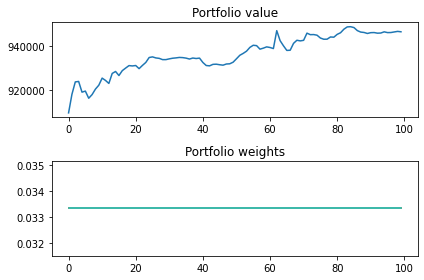

In [23]:
ew_train_benchmark_results_dict = get_eq_wts_benchmark(env = train_env_ret)

In [24]:
ew_train_benchmark_results_dict["performance_stats"]

,Value
Annual return,-0.003844
Cumulative returns,-0.053524
Annual volatility,0.023733
Sharpe ratio,-0.150429
Calmar ratio,-0.021981
Stability,0.743537
Max drawdown,-0.174891
Omega ratio,0.968602
Sortino ratio,-0.209283
Skew,-0.084344


#### Dow Jones benchmarks

### Test with TD3 Agent

In [ ]:
del TD3_WRet

In [25]:
TD3_WRet = PFOpt_DRL_Agent(train_env=train_env_ret)

In [26]:
TD3_RET_PARAMS = {"batch_size": 1, 
              "buffer_size": 10000,
              "learning_rate": 0.01,
              "gamma":0,
              "train_freq": (5, "step"),
              "policy_delay":1,
              "learning_starts":5,
              "action_noise":"ornstein_uhlenbeck",}

In [27]:
TD3_WRet.set_model(model_name = "td3",
                   model_kwargs=TD3_RET_PARAMS,)

{'batch_size': 1, 'buffer_size': 10000, 'learning_rate': 0.01, 'gamma': 0, 'train_freq': (5, 'step'), 'policy_delay': 1, 'learning_starts': 5, 'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
td3 with given parameters has been successfully created.


True

Output()

=================================

Initial portfolio value: 1000000

End portfolio value: 903314.6658327414

Yearly Sharpe ratio at last period: -0.2620794289758158

=================================

Plotting portfolio values and weights for last 100 periods:

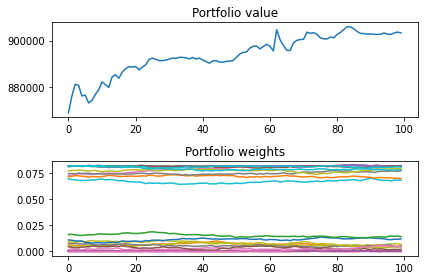

=================================

Initial portfolio value: 1000000

End portfolio value: 906488.959280796

Yearly Sharpe ratio at last period: -0.2526746969095683

=================================

Plotting portfolio values and weights for last 100 periods:

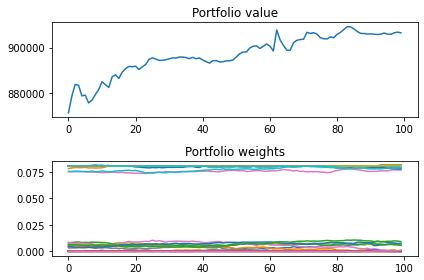

=================================

Initial portfolio value: 1000000

End portfolio value: 905413.9592097048

Yearly Sharpe ratio at last period: -0.25568479723926507

=================================

Plotting portfolio values and weights for last 100 periods:

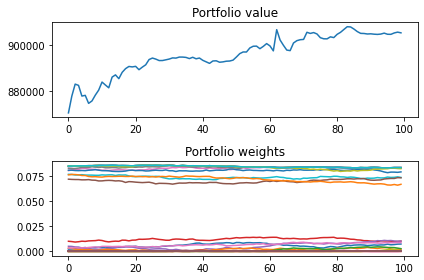

In [28]:
%matplotlib inline
TD3_WRet.train_model(tb_log_name='td3',
                     n_train_rounds=3,
                     progress_bar=True,
                    )

Initial portfolio value: 1000000
End portfolio value: 1026206.1730915554
Yearly Sharpe ratio at last period: 0.9015672209099131
Plotting portfolio values and weights for last 50 periods:


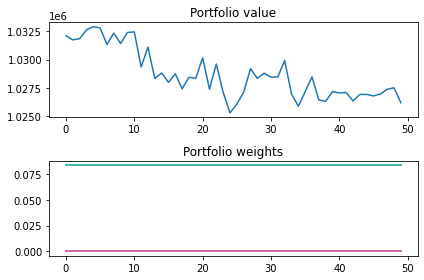

Finished running backtest. Storing results...


In [29]:
TD3_backtest_results_dict = TD3_WRet.run_backtest(test_env=test_env_ret)

Initial portfolio value: 1000000
End portfolio value: 1040071.1242190312
Yearly Sharpe ratio at last period: 1.5782066462033257
Plotting portfolio values and weights for last 50 periods:


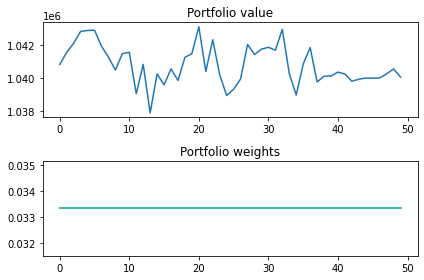

In [30]:
ew_eval_benchmark_results_dict = get_eq_wts_benchmark(env = test_env_ret)

In [31]:
ew_eval_benchmark_results_dict["performance_stats"]

,Value
Annual return,0.032994
Cumulative returns,0.040071
Annual volatility,0.020740
Sharpe ratio,1.575617
Calmar ratio,2.080710
Stability,0.839922
Max drawdown,-0.015857
Omega ratio,1.352936
Sortino ratio,2.606315
Skew,0.631651


Start date,2022-10-25
End date,2022-10-31
Total months,14
,Backtest
Annual return,2.2%
Cumulative returns,2.6%
Annual volatility,2.4%
Sharpe ratio,0.90
Calmar ratio,1.34
Stability,0.67
Max drawdown,-1.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.61,2022-10-26,2022-10-27,2022-10-28,2
1,1.00,2022-10-25,2022-10-25,2022-10-26,1
2,0.92,2022-10-28,2022-10-31,NaT,NaN
3,0.58,2022-10-25,2022-10-25,2022-10-25,1
4,0.27,2022-10-25,2022-10-25,2022-10-25,1


Stress Events,mean,min,max
New Normal,0.01%,-0.66%,0.74%


True

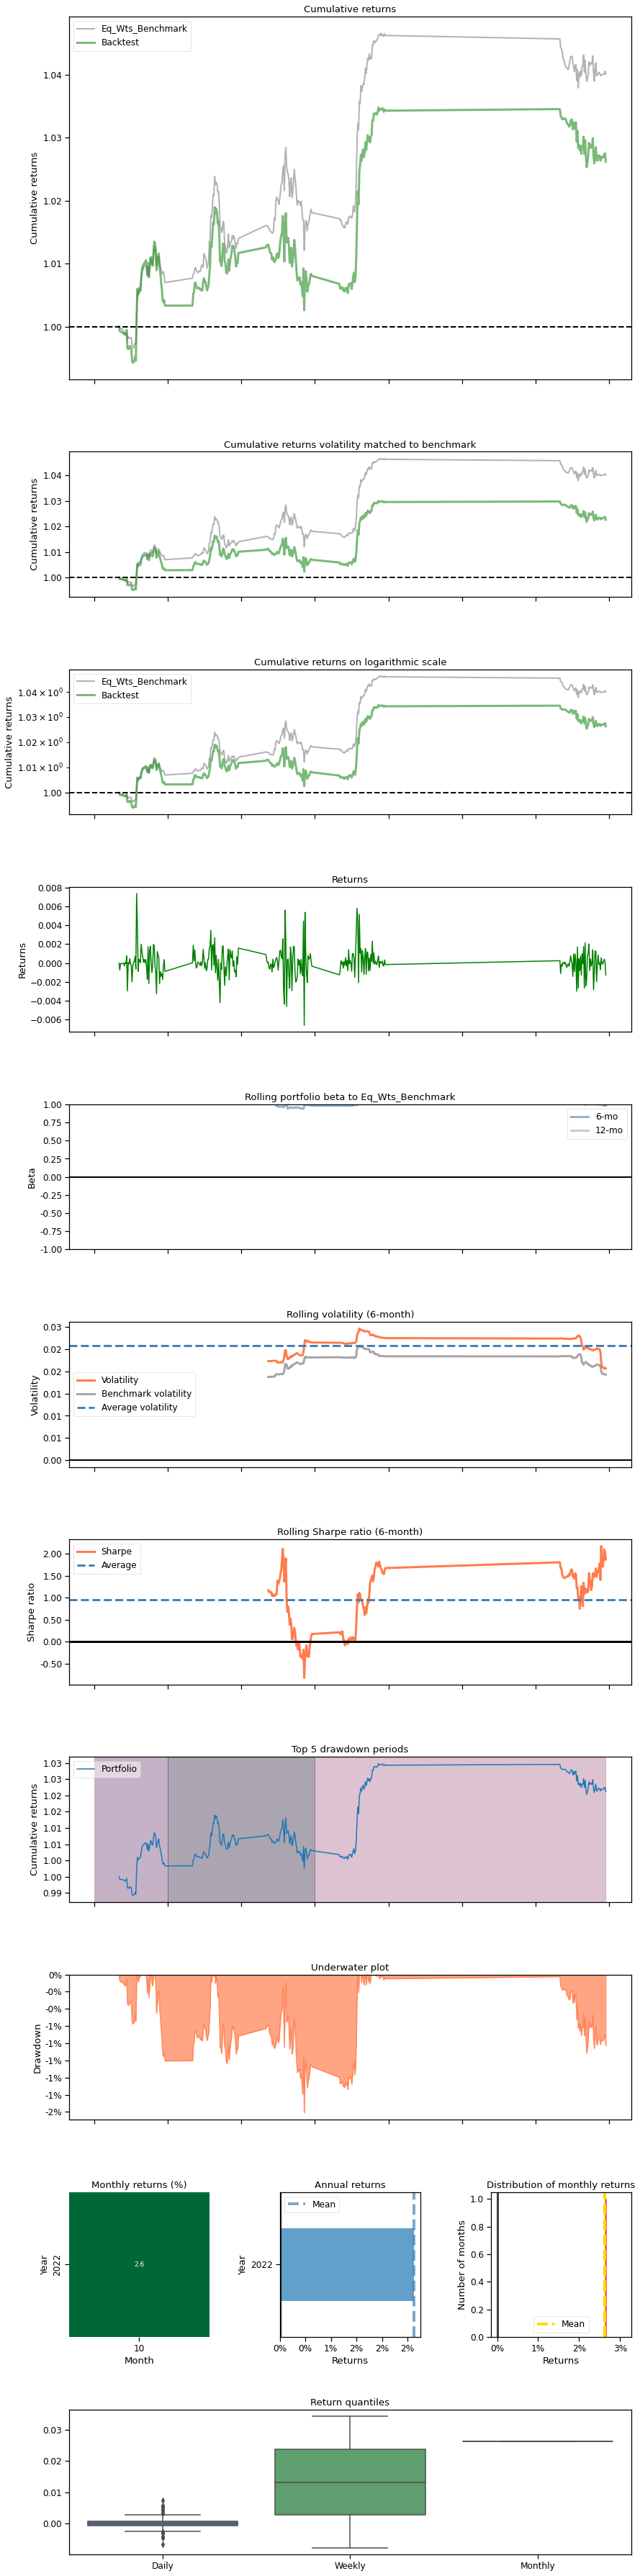

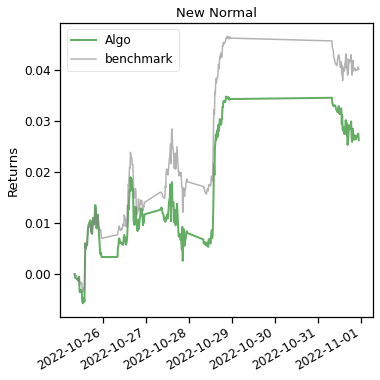

In [32]:
TD3_WRet.plot_backtest_results(df_benchmark_returns=ew_eval_benchmark_results_dict["return_hist"],
                              benchmark_name= "Eq_Wts_Benchmark")

### Test with SAC agent

In [ ]:
del SAC_WRet

In [34]:
SAC_WRet = PFOpt_DRL_Agent(train_env=train_env_ret)

SAC_PARAMS = {
    "batch_size": 1,
    "buffer_size": 100000,
    "learning_rate": 0.001,
    "ent_coef": 0.01,
    "gamma":0,
    "action_noise":"ornstein_uhlenbeck",}

SAC_WRet.set_model(model_name = "sac",
                    model_kwargs=SAC_PARAMS,
                   )

{'batch_size': 1, 'buffer_size': 100000, 'learning_rate': 0.001, 'ent_coef': 0.01, 'gamma': 0, 'action_noise': OrnsteinUhlenbeckActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
sac with given parameters has been successfully created.


True

Output()

=================================

Initial portfolio value: 1000000

End portfolio value: 959603.2680732271

Yearly Sharpe ratio at last period: -0.10787036440247352

=================================

Plotting portfolio values and weights for last 100 periods:

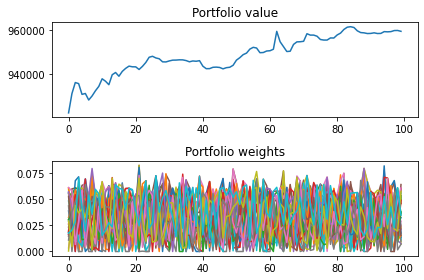

=================================

Initial portfolio value: 1000000

End portfolio value: 949599.8508906572

Yearly Sharpe ratio at last period: -0.13759671199621723

=================================

Plotting portfolio values and weights for last 100 periods:

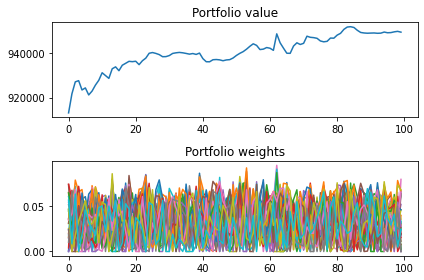

=================================

Initial portfolio value: 1000000

End portfolio value: 918465.7543080475

Yearly Sharpe ratio at last period: -0.23393254730327795

=================================

Plotting portfolio values and weights for last 100 periods:

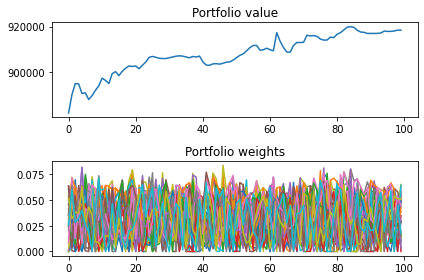

In [35]:
%matplotlib inline
SAC_WRet.train_model(tb_log_name='sac',
                     n_train_rounds=3,
                     progress_bar=True,
                    )

Initial portfolio value: 1000000
End portfolio value: 1040176.692914988
Yearly Sharpe ratio at last period: 1.575176705566386
Plotting portfolio values and weights for last 50 periods:


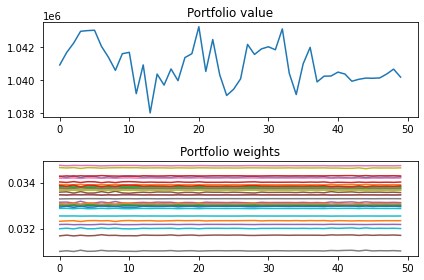

Finished running backtest. Storing results...


In [36]:
SAC_backtest_results_dict = SAC_WRet.run_backtest(test_env=test_env_ret)

Initial portfolio value: 1000000
End portfolio value: 1040071.1242190312
Yearly Sharpe ratio at last period: 1.5782066462033257
Plotting portfolio values and weights for last 50 periods:


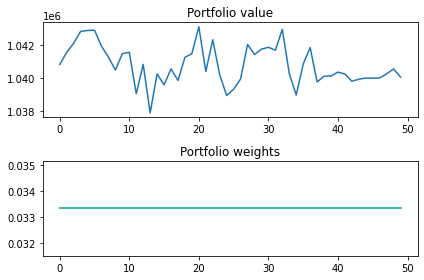

In [37]:
ew_eval_benchmark_results_dict = get_eq_wts_benchmark(env = test_env_ret)

In [38]:
ew_eval_benchmark_results_dict["performance_stats"]

,Value
Annual return,0.032994
Cumulative returns,0.040071
Annual volatility,0.020740
Sharpe ratio,1.575617
Calmar ratio,2.080710
Stability,0.839922
Max drawdown,-0.015857
Omega ratio,1.352936
Sortino ratio,2.606315
Skew,0.631651


Start date,2022-10-25
End date,2022-10-31
Total months,14
,Backtest
Annual return,3.3%
Cumulative returns,4.0%
Annual volatility,2.1%
Sharpe ratio,1.57
Calmar ratio,2.07
Stability,0.84
Max drawdown,-1.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.60,2022-10-27,2022-10-27,2022-10-28,1
1,1.21,2022-10-26,2022-10-26,2022-10-27,1
2,0.83,2022-10-28,2022-10-31,NaT,NaN
3,0.58,2022-10-25,2022-10-25,2022-10-26,1
4,0.39,2022-10-27,2022-10-27,2022-10-27,1


Stress Events,mean,min,max
New Normal,0.01%,-0.48%,0.64%


True

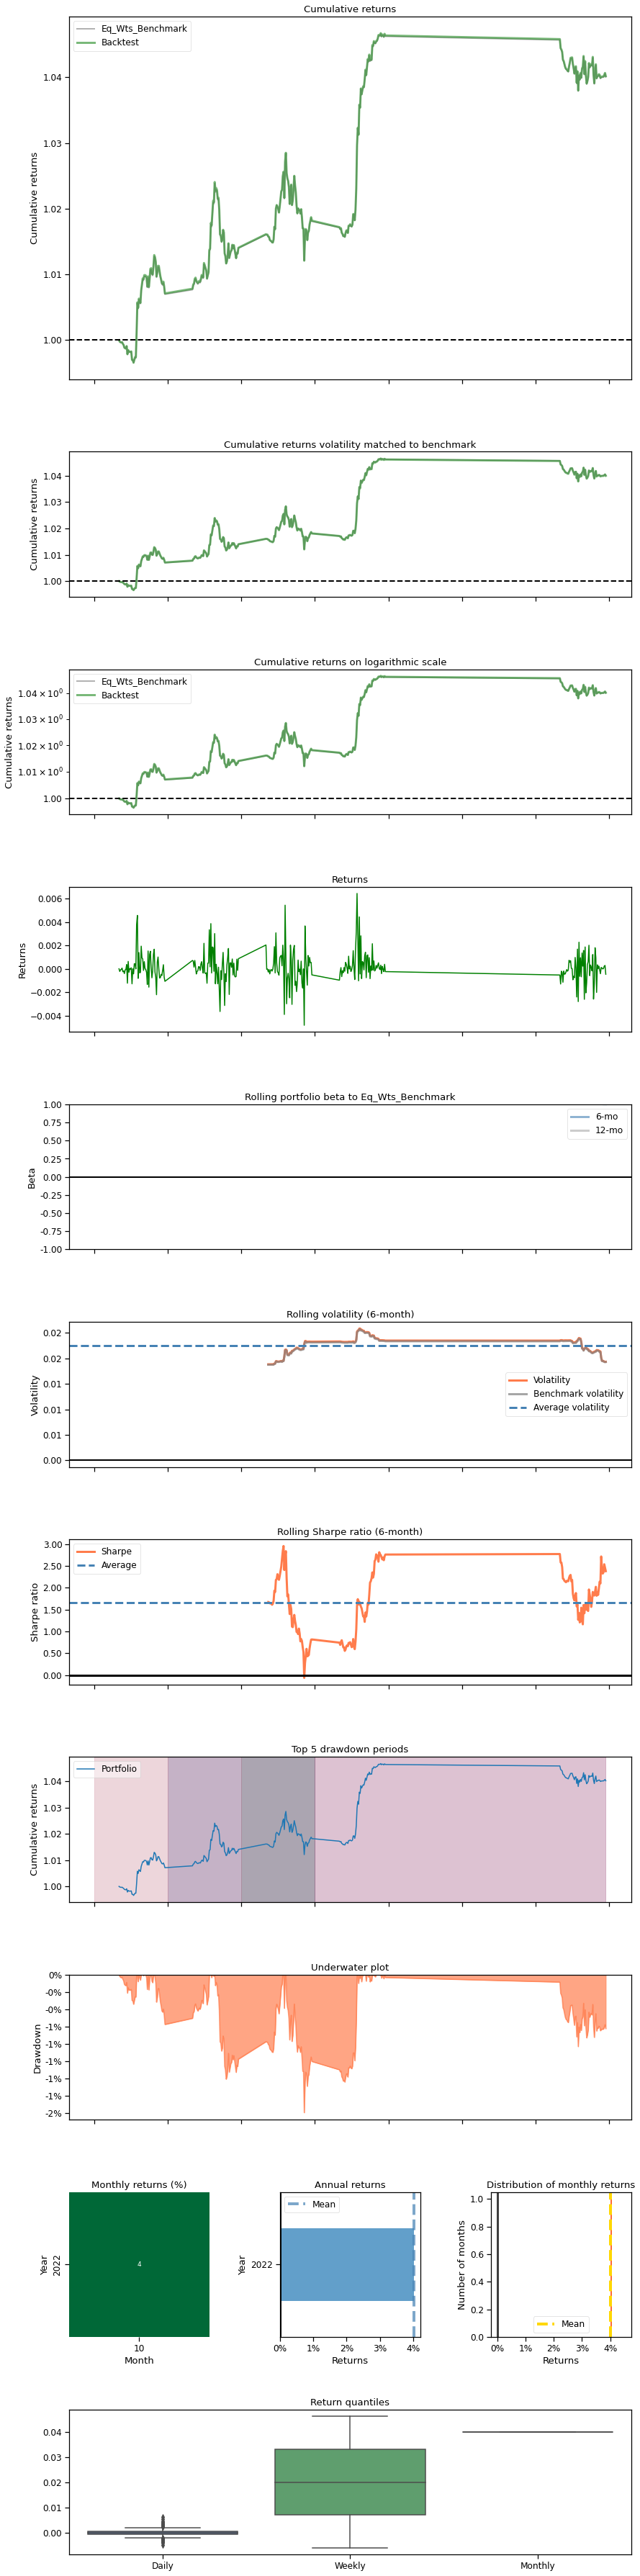

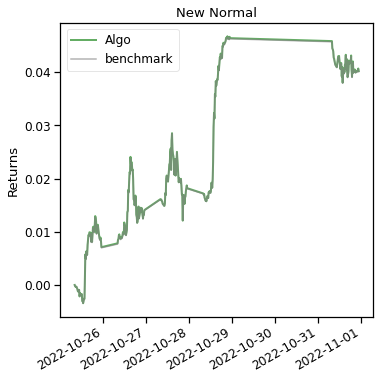

In [39]:
SAC_WRet.plot_backtest_results(df_benchmark_returns=ew_eval_benchmark_results_dict["return_hist"],
                              benchmark_name= "Eq_Wts_Benchmark")

### DJIA Benchmark

Let's check the performance of the Dow Jones during the testing period of 